# Simulation validation of `multidms` models

Jesse developed a pipeline to simulate DMS data to test `dms_variants`. This involved simulating data for a single homolog. Below, to test `multidms`, we simulate data for two homologs, introducing shifts in mutational effects at a subset of sites.

this notebook has 3 major steps involved:

1. Simulate sequences and mutational effects for two homologs, introducing shifts at a subset of sites
2. Defines replicate libraries of variants, Simulating pre, and post-selection library variant counts through a bottleneck, then computing functional scores as noisy target for fitting.
3. multidms modeling and evaluation.

### Import `Python` modules

For this analysis, we'll be using the `dms_variants` package for simulation, with the goal of fitting and validating `multidms` joint-modeling.


In [1]:
import pandas as pd
pd.set_option('display.chop_threshold', 0.001)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks', font_scale=1.5, palette='colorblind')

import Bio.Seq
import collections
import itertools
import random
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP, AAS_NOSTOP, AA_TO_CODONS, AAS_WITHSTOP
from plotnine import *
import multidms

import warnings
warnings.simplefilter("ignore")

### Define notebook parameters

Define the notebook behavior with these parameters:

In [2]:
# TODO, split this up between the different section where each parameter is actually relevant.
# For reproducibility, we set a random seed
seed = 24  # random number seed
random.seed(seed)
np.random.seed(seed)

# define the protein sequence we're going to simulate
genelength = 50  # gene length in codons

# homolog mut effect attributes and shifts
n_non_identical_sites = 10 # number of amino-acid mutations separating homologs
min_muteffect_in_bundle = -1 # minimum effect per mutation
n_shifted_non_identical_sites = 3 
n_shifted_identical_sites = 5
stop_effect = -15 # 15 is the default for `SigmoidPhenotypeSimulator` object - we found that
min_observed_enrichment = 0.01

libs = ["lib_1", "lib_2"]  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.05
bottlenecks = {  # bottlenecks from pre- to post-selection
    "tight_bottle": variants_per_lib * 5,
    "loose_bottle": variants_per_lib * 100,
}

## 1. Simulating experiments

### Simulate a reference sequence

Start by simulating a sequence of nucleotides

First, simulate the sequence of the first homolog.

In [3]:
#genelength = 50  # gene length in codons
geneseq_h1 = "".join(random.choices(CODONS_NOSTOP, k=genelength))
aaseq_h1 = str(Bio.Seq.Seq(geneseq_h1).translate())
print(f"Wildtype gene of {genelength} codons:\n{geneseq_h1}")
print(f"Wildtype protein:\n{aaseq_h1}")

Wildtype gene of 50 codons:
GGTTCCAGTTTTAGTGGAACCGTGAGCGGTGTAGTGCGGTCGTTTACTCTTTTCGTCCGTCAGTTCACCGTGTCCAGCCATCAGGACCCGTGCTGTCATTGCACAACCGGATACTATTTTTCGCAAGTCTGTACCCTGAGCAGACTCGGA
Wildtype protein:
GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG


### Mutational effects and phenotype function

Simulate Mutational effects, $\beta_m$, and post-latent sigmoidal phenotype function, $g(z)$

Simulate latent mutational effects for the first homolog, storing data in a `SigmoidPhenotypeSimulator` object. Also create an identical object for the second homolog. Below, we will update this object to include shifted mutational effects.

In [4]:
# seed = 2
SigmoidPhenotype_h1 = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq_h1, seed=seed, stop_effect=stop_effect, min_observed_enrichment=min_observed_enrichment)
SigmoidPhenotype_h2 = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq_h1, seed=seed, stop_effect=stop_effect, min_observed_enrichment=min_observed_enrichment)

Plot the distribution of mutation effects for the first homolog.

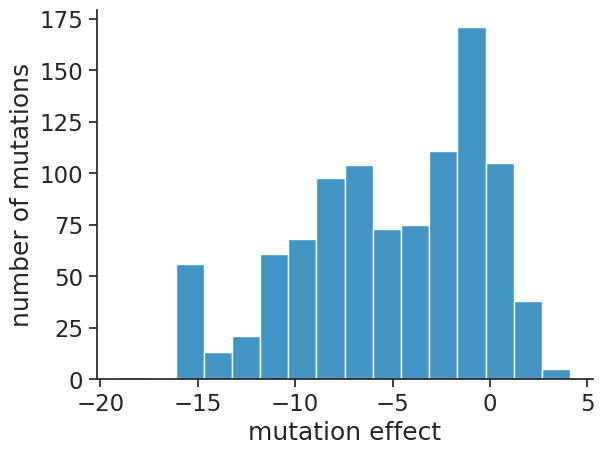

In [5]:
sns.histplot(SigmoidPhenotype_h1.muteffects)
plt.xlabel('mutation effect')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

### Non-reference homolog sequence, and shifted mutational effects

Next, simulate the DNA/protein sequence of second homolog by making a defined number of random amino-acid mutations to the first homolog. Avoid mutations that decrease the latent phenotype by more than two units.

In [6]:
# Input params
random.seed(seed)
non_identical_sites = sorted(random.sample(range(1, len(aaseq_h1)+1), n_non_identical_sites))
aaseq_h2 = ''
geneseq_h2 = ''

# Iterate over each amino acid in the first homolog, and make
# a mutation if indicated.
for (aa_n, aa) in enumerate(aaseq_h1, 1):
    codon = geneseq_h1[(aa_n-1)*3:3*aa_n]
    if aa_n in non_identical_sites:
        mut_aas = [
            mut_aa for mut_aa in AAS_NOSTOP
            if (mut_aa != aa) and (SigmoidPhenotype_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] > min_muteffect_in_bundle)
        ]
        assert len(mut_aas) > 0, aa_n
        mut_aa = random.choice(mut_aas)
        aaseq_h2 += mut_aa
        mut_codon = random.choice(AA_TO_CODONS[mut_aa])
        geneseq_h2 += mut_codon
    else:
        aaseq_h2 += aa
        geneseq_h2 += codon

# Store and summarize results
homolog_seqs = {
    1 : aaseq_h1,
    2 : aaseq_h2
}
n_diffs = sum([aa1 != aa2 for (aa1, aa2) in zip(aaseq_h1, aaseq_h2)])
print('Sequence alignment of homologs h1 and h2:')
print('h1', aaseq_h1)
print('h2', aaseq_h2)
print('Number of aa differences:', n_diffs)
assert len(aaseq_h1) == len(aaseq_h2)
assert aaseq_h2 == str(Bio.Seq.Seq(geneseq_h2).translate())
assert n_diffs == len(non_identical_sites)

Sequence alignment of homologs h1 and h2:
h1 GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG
h2 GSSFSPTVSCCSWWFTLFVRQFTVHSHQDPCCHCTTGWYFSQVCGNSRLG
Number of aa differences: 10


Next, randomly choose a subset of sites that will have shifted mutational effects. Do this independently for sites that are identical and non-identical between homologs, so that we are sure to have shifted sites in each category.

In [7]:
# Non-identical sites
random.seed(seed)
shifted_non_identical_sites = sorted(random.sample(
    non_identical_sites,
    n_shifted_non_identical_sites
))

# Identical sites
identical_sites = [
    i for i in range(1, len(aaseq_h1)+1)
    if i not in non_identical_sites
]
shifted_identical_sites = sorted(random.sample(
    identical_sites,
    n_shifted_identical_sites
))

# Make a list of all shifted sites
shifted_sites = sorted(shifted_identical_sites + shifted_non_identical_sites)
assert len(shifted_sites) == len(set(shifted_sites))
print('Sites with shifts that are...')
print(f'identical (n={len(shifted_identical_sites)}):', ', '.join(map(str, shifted_identical_sites)))
print(f'non-identical (n={len(shifted_non_identical_sites)}):', ', '.join(map(str, shifted_non_identical_sites)))

Sites with shifts that are...
identical (n=5): 7, 16, 17, 19, 26
non-identical (n=3): 11, 12, 25


At each of the above sites, randomly simulate a shift in the effect of each mutation by drawing shifts from a Gaussian distribution.

In [8]:
# TODO possibly have different rate parameters for each site.
def sim_mut_shift(shifted_site, mutation):
    if (not shifted_site) or ('*' in mutation):
        return 0
    else:
        return np.random.normal(loc=0, scale=1.5, size=1)[0]

# Make a dataframe of mutation effects in the first homolog
mut_effects_df = pd.DataFrame.from_dict(
    SigmoidPhenotype_h1.muteffects,
    orient='index',
    columns=['beta_h1']
)
mut_effects_df.reset_index(inplace=True)
mut_effects_df.rename(columns={'index':'mutation'}, inplace=True)
mut_effects_df['wt_aa'] = mut_effects_df['mutation'].str.extract(r'([\w*])\d+[\w*]')
mut_effects_df['site'] = mut_effects_df['mutation'].str.extract(r'[\w*](\d+)[\w*]')
mut_effects_df['site'] = mut_effects_df['site'].astype(int)
mut_effects_df['mut_aa'] = mut_effects_df['mutation'].str.extract(r'[\w*]\d+([\w*])')

# Simulate shifts for all mutations in the pre-defined
# list of shifted sites, ignorning mutations to stop codons
mut_effects_df['shifted_site'] = mut_effects_df['site'].apply(
    lambda x: x in shifted_sites
)
np.random.seed(seed)
mut_effects_df['shift'] = mut_effects_df.apply(
    lambda row: sim_mut_shift(
        row['shifted_site'],
        row['mutation']
    ),
    axis=1
)

# Add column that gives mutation effects in the second homolog
mut_effects_df['beta_h2'] = mut_effects_df['beta_h1'] + mut_effects_df['shift']

# Add columns that give the wildtype amino acids of
# each homolog at each site
for (homolog, seq) in homolog_seqs.items():
    seq_dict = {
        key : []
        for key in ['site', f'aaseq_h{homolog}']
    }
    for (i, aa) in enumerate(seq, 1):
        seq_dict['site'].append(i)
        seq_dict[f'aaseq_h{homolog}'].append(aa)
    seq_df = pd.DataFrame.from_dict(seq_dict)
    mut_effects_df = mut_effects_df.merge(seq_df, on='site')

# Show data for a subset of sites with shifts
mut_effects_df[mut_effects_df['shifted_site'] == True][[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site'
]]

site aaseq_h1 aaseq_h2 mutation    beta_h1     shift    beta_h2  \
120     7        T        T      T7A  -2.826142  1.993818  -0.832324   
121     7        T        T      T7C  -6.883536 -1.155050  -8.038586   
122     7        T        T      T7D -14.643914 -0.474421 -15.118335   
123     7        T        T      T7E  -6.330193 -1.486216  -7.816408   
124     7        T        T      T7F  -7.924448 -1.606224  -9.530672   
..    ...      ...      ...      ...        ...       ...        ...   
515    26        S        S     S26T  -1.060161  0.464347  -0.595814   
516    26        S        S     S26V  -2.942979 -1.358177  -4.301156   
517    26        S        S     S26W -13.127808  2.822089 -10.305719   
518    26        S        S     S26Y -10.869046 -0.339584 -11.208630   
519    26        S        S     S26* -15.000000  0.000000 -15.000000   

     shifted_site  
120          True  
121          True  
122          True  
123          True  
124          True  
..            ...  
515          True  
516          True  
517          True  
518          True  
519          True  

[160 rows x 8 columns]

Plot the distribution of all simulated shifts, excluding mutations to stop codons and sites that have no shifted effects.

Number of mutations with shifts: 152


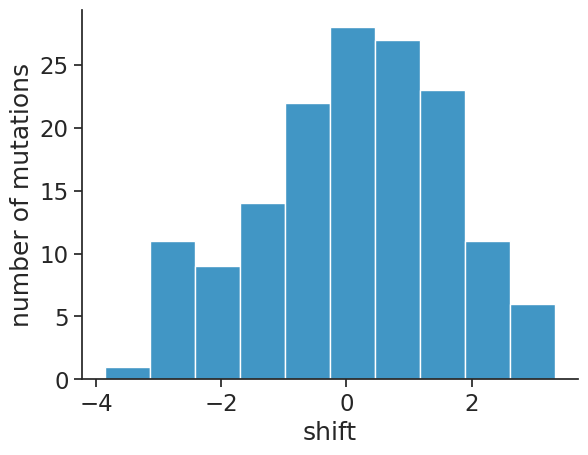

In [9]:
data = mut_effects_df[
    (mut_effects_df['site'].isin(shifted_sites)) &
    ~(mut_effects_df['mutation'].str.contains('\*'))
]
print('Number of mutations with shifts:', len(data))
sns.histplot(data['shift'])
plt.xlabel('shift')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

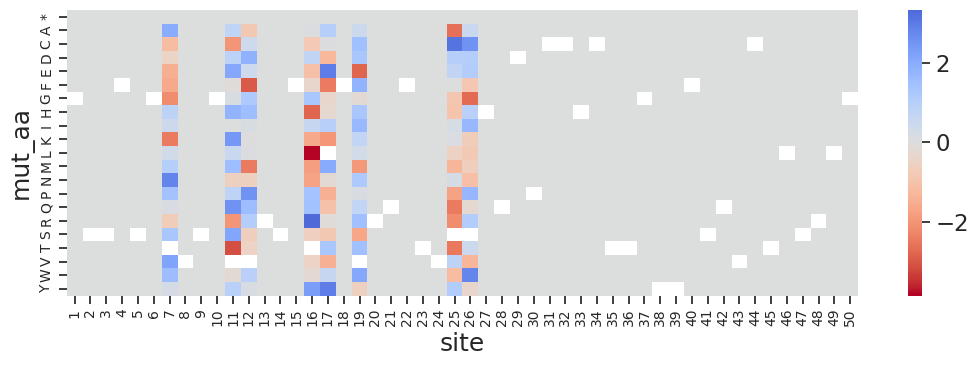

In [10]:

%matplotlib inline

sort_order = sorted([
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","*",
])

fig, ax = plt.subplots(figsize=[11, 4])
sns.heatmap(
    data=mut_effects_df.pivot(index='mut_aa', columns='site', values='shift').loc[sort_order],
    cmap="coolwarm_r",
    center=0,
    ax=ax,
)
ax.set_yticks(
    [s+0.5 for s in range(len(sort_order))],
    labels=sort_order, 
    va="center",
    size=10
)
sites = range(1, 51)
ax.set_xticks(
    [s+0.5 for s in range(len(sites))],
        labels=sites, 
        ha="center",
    rotation=90,
    size=10
)
plt.tight_layout()
plt.show()

Above, we created a `SigmoidPhenotypeSimulator` object for the second homolog by making a copy of the one for the first homolog. This object stores the homolog's wildtype latent phenotype and the latent effects of individual mutations. Below, we update both of these traits based on the simulated shifts from above. To update the wildtype latent phenotype, we will add the effects of all mutations that separate the homologs. In computing this sum, we will use $\beta$ parameters for the second homolog, which already include shifted effects.

In [11]:
# Update individual mutational effects
assert sum(mut_effects_df['mutation'].duplicated()) == 0
for mutation in SigmoidPhenotype_h2.muteffects.keys():
    SigmoidPhenotype_h2.muteffects[mutation] = float(mut_effects_df[mut_effects_df['mutation']==mutation]['beta_h2'])

# Update the wildtype latent phenotype

# grab bundle of mutations separating the two homologs
data = mut_effects_df[
    (mut_effects_df['site'].isin(non_identical_sites)) &
    (mut_effects_df['mut_aa'] == mut_effects_df['aaseq_h2'])
]
# print(data.shape)

wt_latent_phenotype_shift = sum(data['beta_h2'])
SigmoidPhenotype_h2.wt_latent = SigmoidPhenotype_h1.wt_latent + wt_latent_phenotype_shift
print('Characteristics of mutations separating homologs:')
for metric in ['beta_h1', 'shift', 'beta_h2']:
    print(f'Sum of {metric}:', round(sum(data[metric]), 2))
print('Final WT latent phenotype of h2:', round(SigmoidPhenotype_h2.wt_latent, 2))
print('Table of mutations that separate homologs:')
data[[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site', 
]]

Characteristics of mutations separating homologs:
Sum of beta_h1: 2.91
Sum of shift: -3.64
Sum of beta_h2: -0.73
Final WT latent phenotype of h2: 4.27
Table of mutations that separate homologs:


site aaseq_h1 aaseq_h2 mutation   beta_h1     shift   beta_h2  \
111     6        G        P      G6P  0.774939  0.000000  0.774939   
181    10        G        C     G10C -0.666580  0.000000 -0.666580   
201    11        V        C     V11C -0.017674 -2.005404 -2.023077   
235    12        V        S     V12S -0.105813 -0.653983 -0.759795   
257    13        R        W     R13W  2.731780  0.000000  2.731780   
277    14        S        W     S14W  0.764167  0.000000  0.764167   
486    25        S        H     S25H -0.635094 -0.982819 -1.617913   
758    38        Y        W     Y38W  1.638478  0.000000  1.638478   
885    45        T        G     T45G -0.879462  0.000000 -0.879462   
910    46        L        N     L46N -0.690706  0.000000 -0.690706   

     shifted_site  
111         False  
181         False  
201          True  
235          True  
257         False  
277         False  
486          True  
758         False  
885         False  
910         False

All mutations in the second homolog's `SigmoidPhenotypeSimulator` object are defined relative to the wildtype sequence of the first homolog, which we will call the "reference" homolog.
But, to simulate data for the second homolog, we need entries to be relative to the wildtype sequence of the second homolog.
These entries are missing for sites at which the homologs differ in sequence.
For instance, if the wildtype amino acid at site 30 is an A in the first homolog, but is a Y in a second homolog, then the effect of a Y30G is absent from the second homolog's simulator object.

To add these missing entries, we will use a strategy that assumes additivity between mutations at the same site.
For instance, in the above example, a Y30G mutation is defined as the sum of the following two mutations relative to A: A30Y (negated) and A30G.
This approach assumes that mutational effects can be negated, such that A30Y has the opposite effect as Y30A.
It also assumes that mutational effects are additive, such that the effect of Y30G is the sum of the effects of Y30A and A30G.

The below expression defines this approach more explicitly for an arbitrary site.
It uses the notation $\beta_{x,n,z}$ where $x$ and $z$ are amino acids.
For a site $n$, if $aa_{\text{wt}}$ is the site's wildtype amino acid in a non-reference homolog, $aa_{\text{mut}}$ is a mutant amino acid in a variant of that homolog, and $aa_{\text{ref}}$ is the site's wildtype amino acid in the reference homolog, then the mutation's effect is:

$$\beta_{aa_{\text{wt}},n,aa_{\text{mut}}} = \begin{cases}
      \beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{if } aa_{\text{wt}} = aa_{\text{ref}}\\
      -\beta_{aa_{\text{ref}},n,aa_{\text{wt}}} & \text{if } aa_{\text{mut}} = aa_{\text{ref}}\\
      - \beta_{aa_{\text{ref}},n,aa_{\text{wt}}} +\beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{otherwise}\\
\end{cases}$$

The above $\beta$ parameters are effects in the background of the non-reference homolog, such that they account for shifts in mutational effects between homologs.

The below cell adds mutational effects for missing entries using the above strategy.

In [12]:
# Iterate over non-identical sites
# -15 might not accuarately reflect just how deleterious these should be compared to an laten wildtype
# phenotype of 5 (which is seemingly the default).
for site in non_identical_sites:
    
    aa_h1 = aaseq_h1[site-1]
    aa_h2 = aaseq_h2[site-1]
    assert (aa_h1 != aa_h2), site
    
    # Get the effect of the mutation that goes between homologs
    mut_between_homologs = f'{aa_h1}{site}{aa_h2}'
    mut_between_homologs_effect = float(mut_effects_df[
        mut_effects_df['mutation'] == mut_between_homologs
    ]['beta_h2'])
    
    # Iterate over mutant amino acids and add an entry for
    # each one
    for aa_mut in AAS_WITHSTOP:
        if aa_h2 == aa_mut:
            continue
        elif aa_mut == '*':
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = stop_effect
        elif aa_mut == aa_h1:
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect
        else:            
            # Get the effect of the mutation that goes from the
            # reference amino acid to the original mutant amino acid
            mut_from_ref = f'{aa_h1}{site}{aa_mut}'
            mut_from_ref_effect = float(mut_effects_df[
                mut_effects_df['mutation'] == mut_from_ref
            ]['beta_h2'])
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect + mut_from_ref_effect

In [13]:
mut_effects_df.head()

mutation   beta_h1 wt_aa  site mut_aa  shifted_site  shift   beta_h2  \
0      G1A -5.811474     G     1      A         False    0.0 -5.811474   
1      G1C -8.878036     G     1      C         False    0.0 -8.878036   
2      G1D -1.013877     G     1      D         False    0.0 -1.013877   
3      G1E -8.349956     G     1      E         False    0.0 -8.349956   
4      G1F -1.349155     G     1      F         False    0.0 -1.349155   

  aaseq_h1 aaseq_h2  
0        G        G  
1        G        G  
2        G        G  
3        G        G  
4        G        G

## 2. Simulate variants libraries and selection

### Variant libraries with phenotypes and enrichments

Simulate a library of variants that one might use in an actual experiment independently for each homolog, each with two independent replicate libraries.

In [14]:
CodonVariantTable_h1 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h1,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)
CodonVariantTable_h2 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h2,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)

In [15]:
CodonVariantTable_h1.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

In [16]:
len(CodonVariantTable_h2.barcode_variant_df.barcode.unique())

50000

plot the number of variant support sequences as a histogram

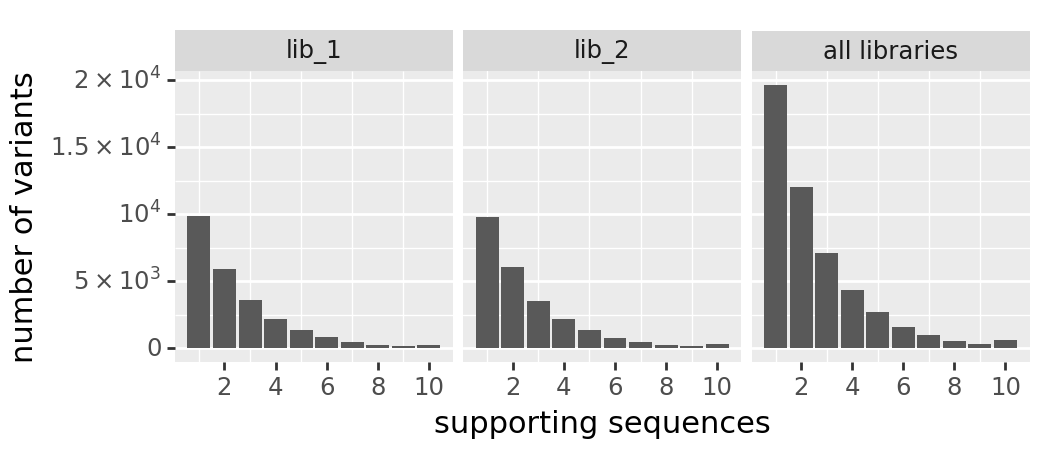

In [17]:
p = CodonVariantTable_h1.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

In [18]:
CodonVariantTable_h2.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

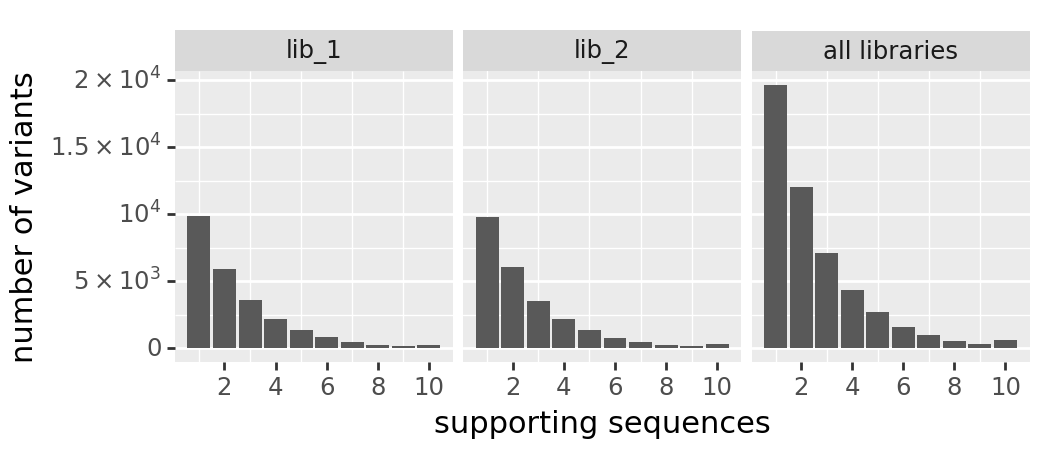

In [19]:
p = CodonVariantTable_h2.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)


For each homolog, simulate latent and observed phenotypes for each variant given the underlying mutation effects from above.

In [20]:
# First homolog
phenotypes_h1 = [
    (SigmoidPhenotype_h1.latentPhenotype, 'latent_phenotype'),
    (SigmoidPhenotype_h1.observedPhenotype, 'observed_phenotype'),
    (SigmoidPhenotype_h1.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h1:
    CodonVariantTable_h1.barcode_variant_df[col_name] = \
        CodonVariantTable_h1.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))
    
# Second homolog
phenotypes_h2 = [
    (SigmoidPhenotype_h2.latentPhenotype, 'latent_phenotype'),
    (SigmoidPhenotype_h2.observedPhenotype, 'observed_phenotype'),
    (SigmoidPhenotype_h2.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h2:
    CodonVariantTable_h2.barcode_variant_df[col_name] = \
        CodonVariantTable_h2.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))

# # Get dataframes listing variants
# v1_df = CodonVariantTable_h1.barcode_variant_df
# v2_df = CodonVariantTable_h2.barcode_variant_df

As in Jesse's notebook, the above computation uses a sigmoid to convert a latent phenotype to an observed one. Below, we plot these sigmoids for the first homolog.

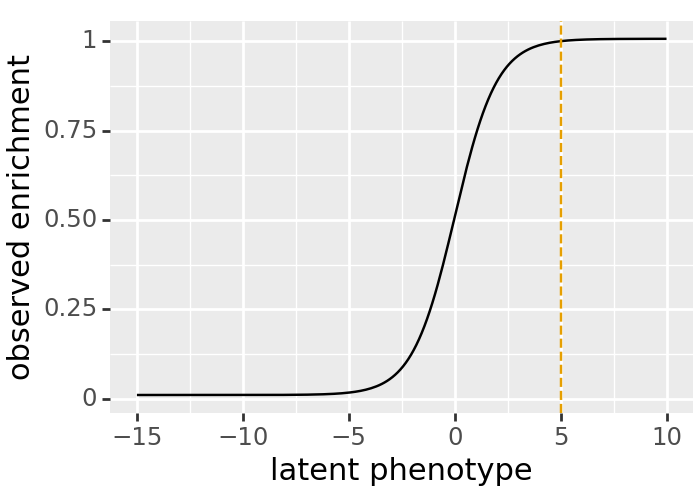

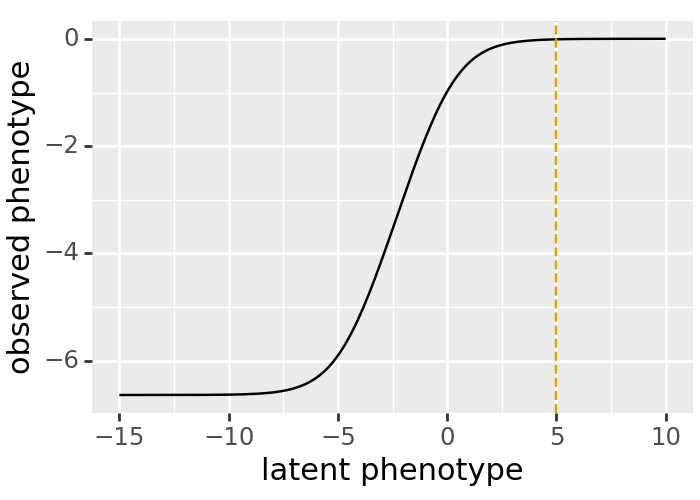

In [21]:

for value in ["enrichment", "phenotype"]:
    p = SigmoidPhenotype_h1.plotLatentVsObserved(value)
    p.draw(show=True)

... and the second homolog:

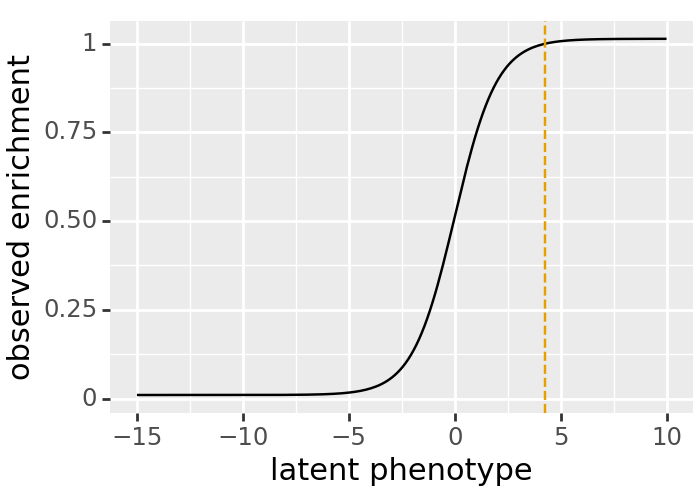

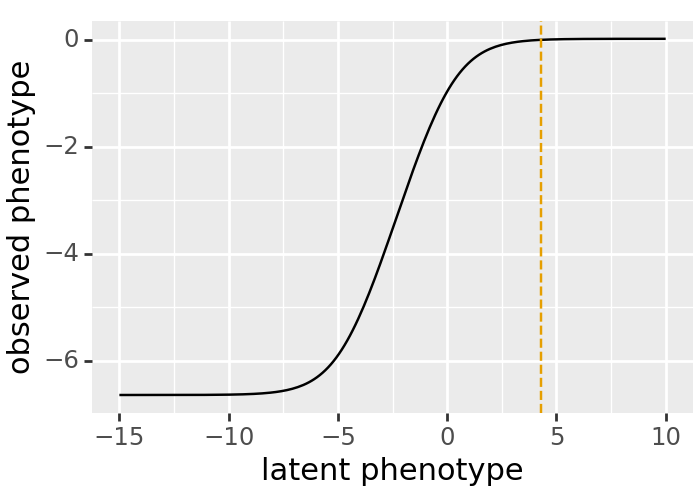

In [22]:
import plotnine
for value in ["enrichment", "phenotype"]:
    p = SigmoidPhenotype_h2.plotLatentVsObserved(value)
    _ = p.draw(show=True)

Show example data for variants for the first homolog.

In [23]:
CodonVariantTable_h1.barcode_variant_df.head()

library           barcode  variant_call_support  \
0   lib_1  AAAAAAGAAATTGGAC                     4   
1   lib_1  AAAAAAGAACCGTACA                     2   
2   lib_1  AAAAAAGGCCGGACGC                     5   
3   lib_1  AAAAACGTTATGAGGC                     1   
4   lib_1  AAAAACTGGGCGACCG                     3   

                                 codon_substitutions  \
0  GTG24CAG TCC25AGG CAT27CCC GAC29TTG CAT33TGT T...   
1                 GTG8CCA CAT27ACG CCG30TAA CTC49CCG   
2                                  GTC19CCG GTC43CAG   
3                                           CGT20TAC   
4                                                      

                          aa_substitutions  n_codon_substitutions  \
0  V24Q S25R H27P D29L H33C S41L C44F S47F                      8   
1                       V8P H27T P30* L49P                      4   
2                                V19P V43Q                      2   
3                                     R20Y                      1   
4                                                               0   

   n_aa_substitutions  latent_phenotype  observed_phenotype  \
0                   8        -23.431108           -6.643856   
1                   4        -16.121890           -6.643842   
2                   2         -8.857904           -6.623548   
3                   1          2.855227           -0.070300   
4                   0          5.000000            0.000000   

   observed_enrichment  
0             0.010000  
1             0.010000  
2             0.010142  
3             0.952440  
4             1.000000

In [24]:
np.all(mut_effects_df['wt_aa'] == mut_effects_df['aaseq_h1'])

True

### Simulate counts

Next, we would like to simulate both pre and post-selection counts of each variant in each experiment in proportion to their ground-truth `"observed_enrichment"`. Post selection counts will be simulated by applying the specified selection bottleneck(s), to the pre-selection counts. 



Note that the counts are simulated proportianlly to the observed *enrichment*, not the observed *phenotype*.
The enrichment for a given variant $v$ is defined as $E(v) = B^{(p(v)-p(wt))}$, where $p(v)$ is the observed phenotype of variant $v$, and $p(wt)$ is the observed phenotype of the wildtype.

 To do this, we will use the `simulate_counts` function from `dms_variants.simulate` and the `compute_scores` function from `dms_variants.codonvarianttable`.

In [25]:
# do this independently for each of the homologs.
counts_h1, counts_h2 = [
    dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={
            "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
            "uniformity": lib_uniformity,
        },
        pre_sample_name="pre-selection",
        post_samples={
            name: {
                "noise": noise,
                "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
                "bottleneck": bottleneck,
            }
            for name, bottleneck in bottlenecks.items()
        },
        seed=seed,
    )
    for variants, phenosimulator in zip(
        [CodonVariantTable_h1, CodonVariantTable_h2], [SigmoidPhenotype_h1, SigmoidPhenotype_h2]
    )
]
CodonVariantTable_h1.add_sample_counts_df(counts_h1)
CodonVariantTable_h2.add_sample_counts_df(counts_h2)

In [26]:
CodonVariantTable_h1.n_variants_df()

library         sample    count
0          lib_1  pre-selection  4725000
1          lib_1   loose_bottle  4925000
2          lib_1   tight_bottle  4625000
3          lib_2  pre-selection  4725000
4          lib_2   loose_bottle  4925000
5          lib_2   tight_bottle  4625000
6  all libraries  pre-selection  9450000
7  all libraries   loose_bottle  9850000
8  all libraries   tight_bottle  9250000

Plot the number of counts for each variant in each sample. The horizontal dashed line shows the total number of variants. The plot shows that all variants are well-sampled in the pre-selection libraries, but that post- selection some variants are sampled more or less. This is expected since selection will decrease and increase the frequency of variants:

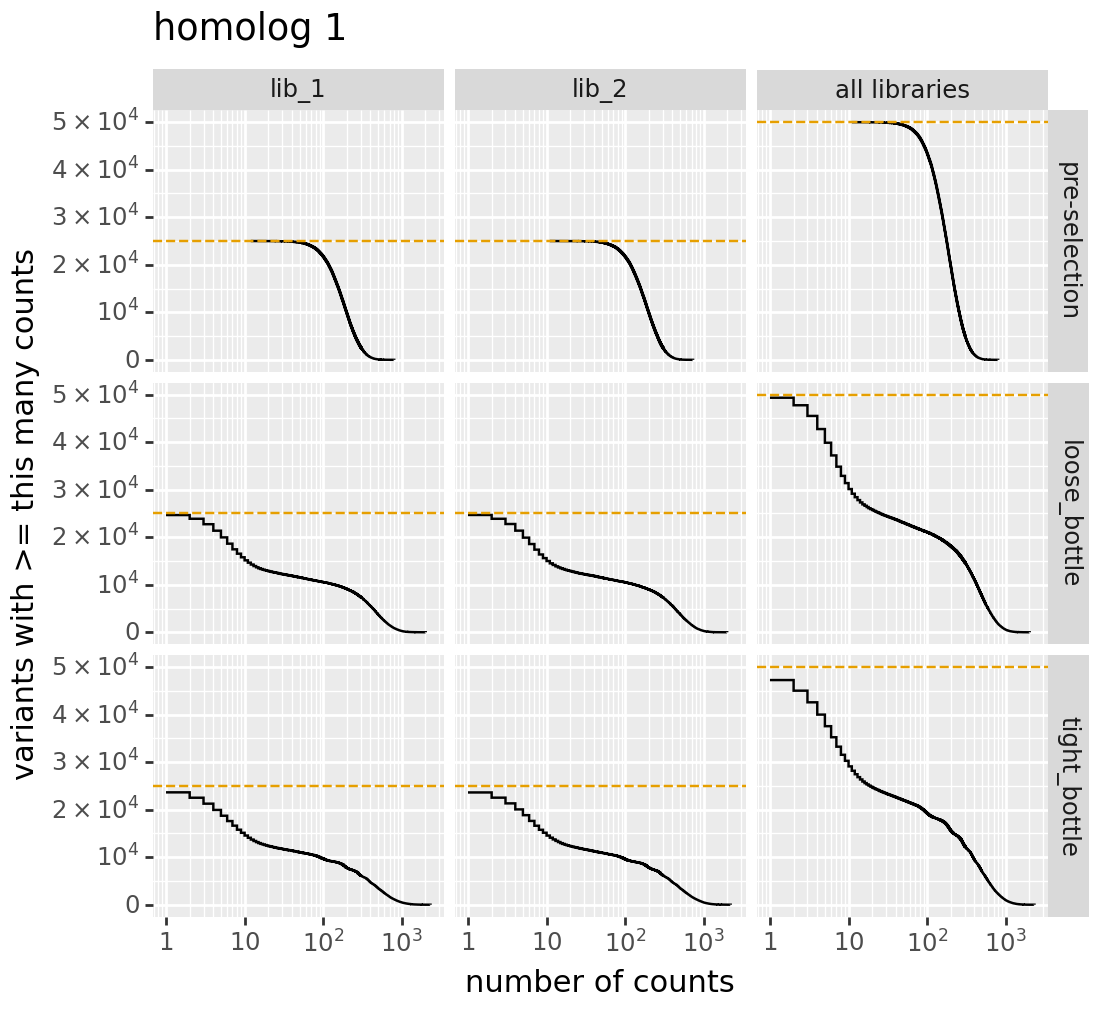

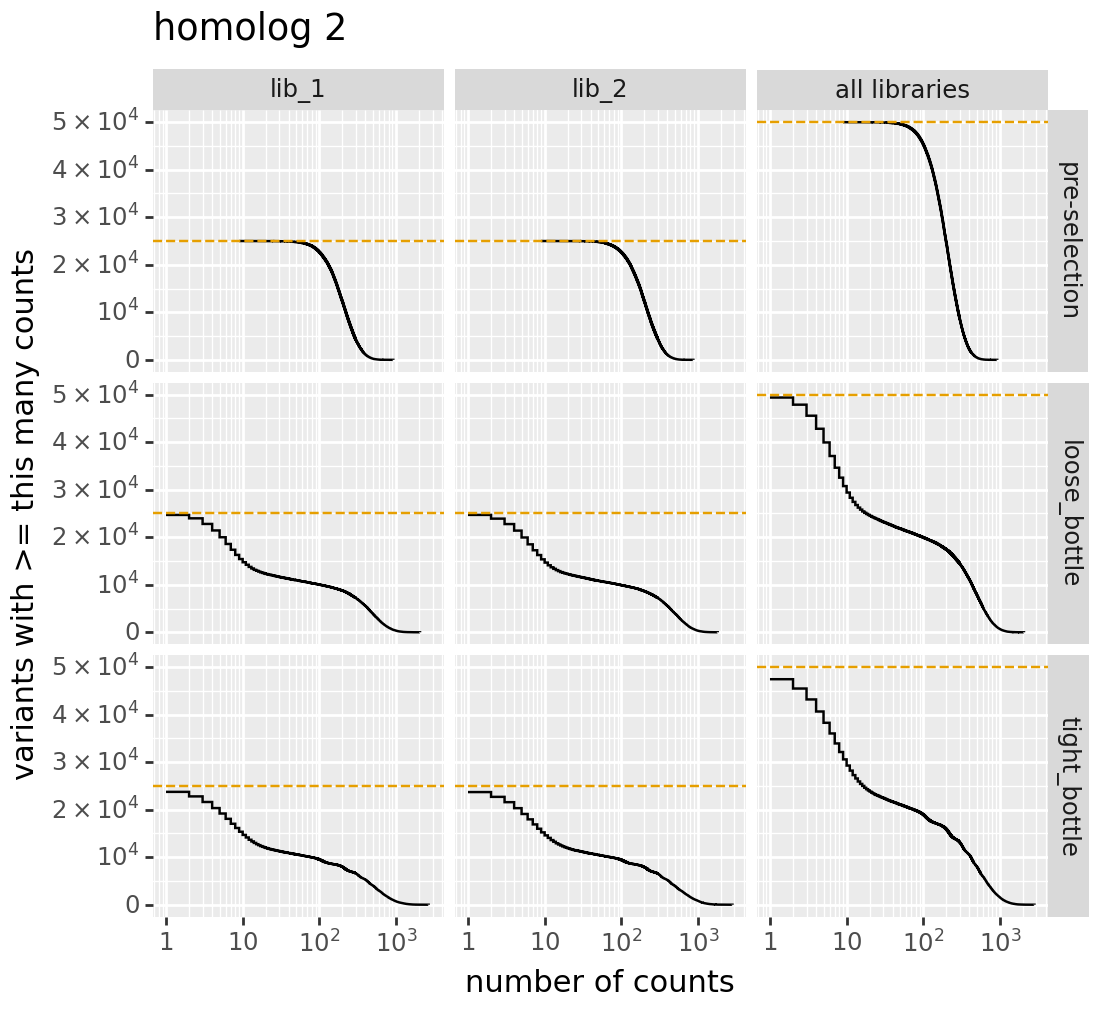

In [27]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotCumulVariantCounts()
    p += labs(title=title)
    _ = p.draw(show=True)

Distribution of the number of amino-acid mutations per variant in each sample. As expected, mutations go down after selection:

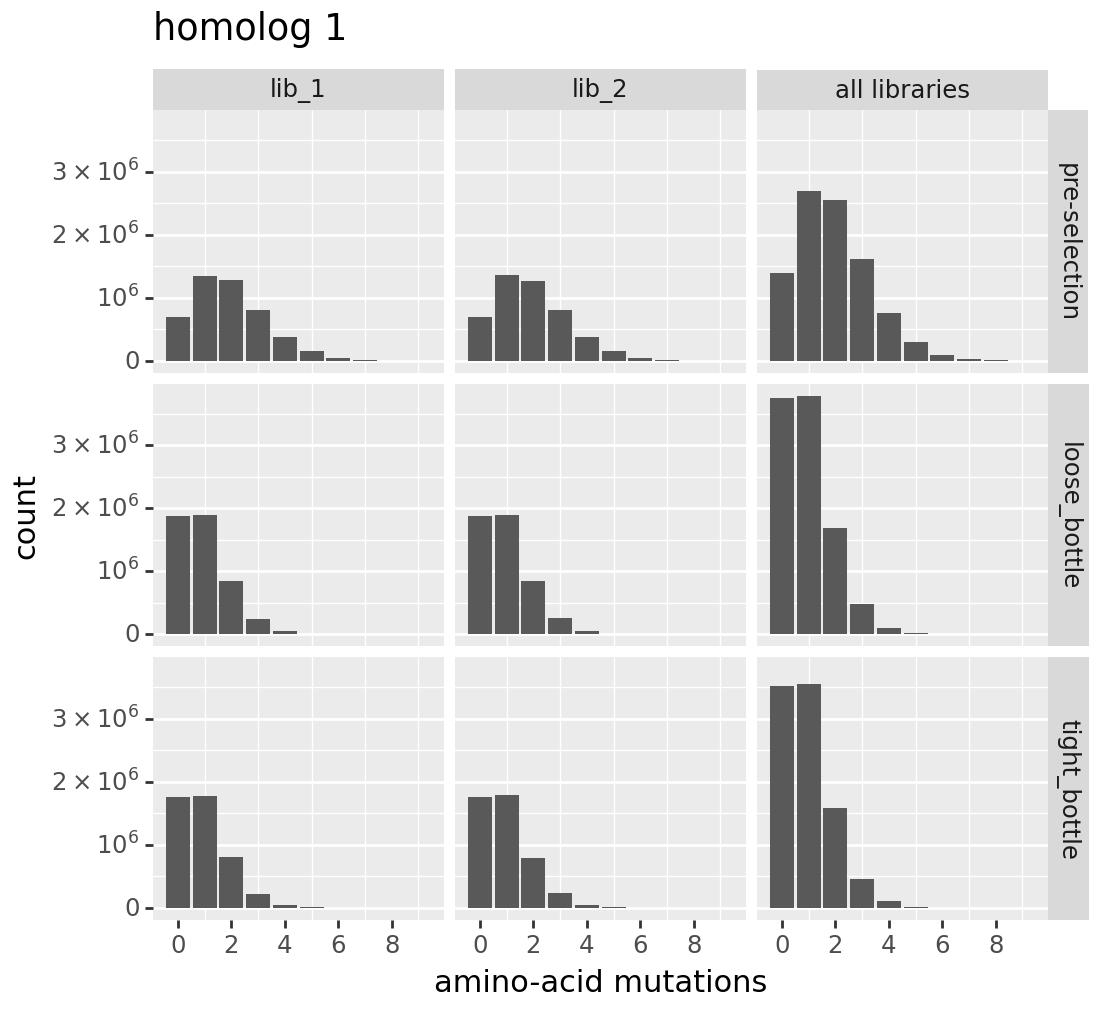

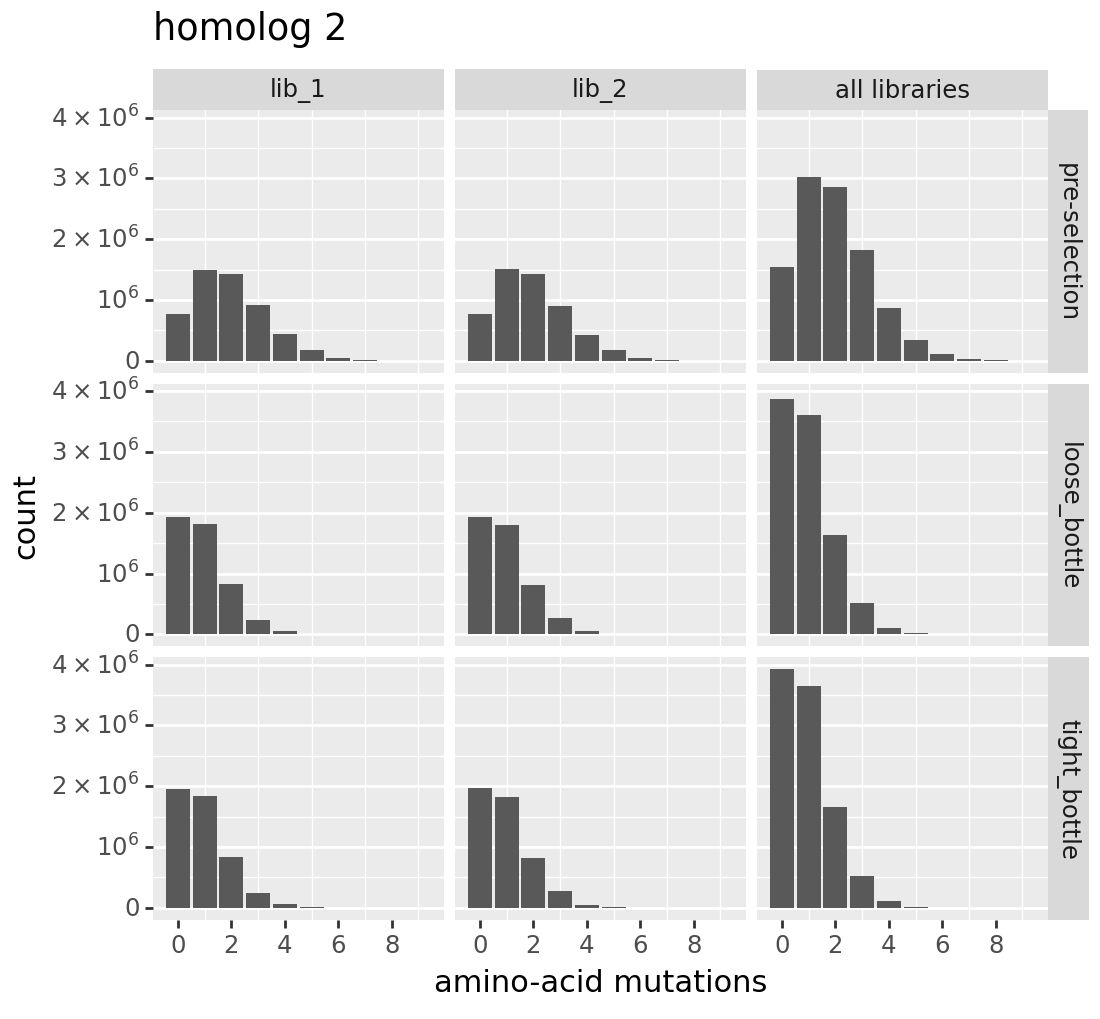

In [28]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotNumMutsHistogram(mut_type="aa")
    p += theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    p += labs(title=title)
    _ = p.draw(show=True)

Plot how thoroughly amino-acid mutations are sampled, doing this separately among all variants and single-mutant variants. The plots below show that the stop mutations are sampled very poorly post-selection because they are eliminated during selection:

<Figure size 640x480 with 0 Axes>

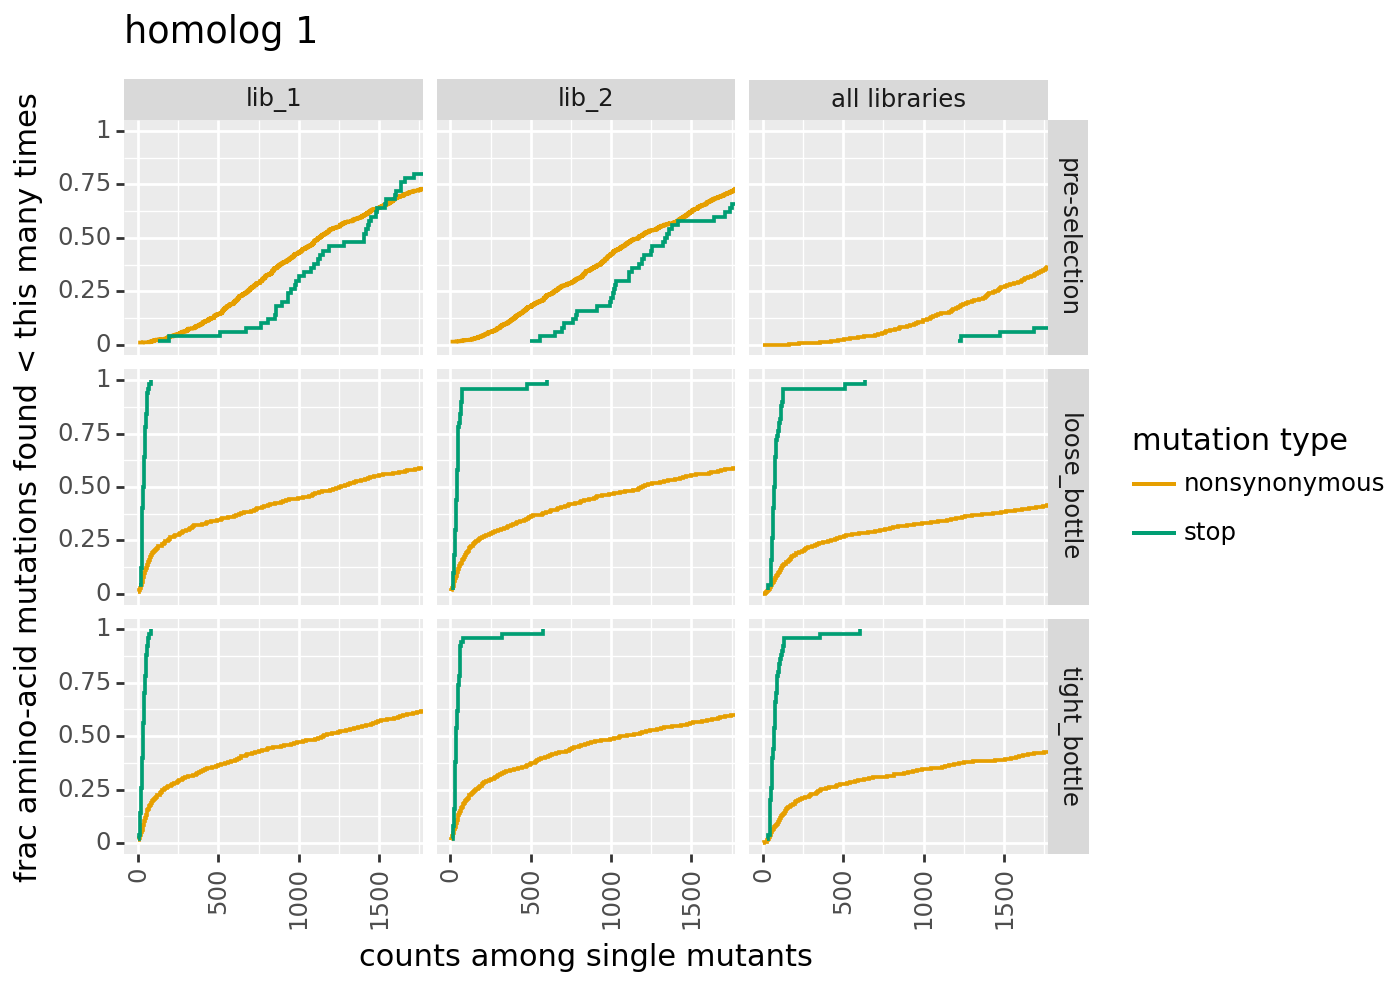

<Figure size 640x480 with 0 Axes>

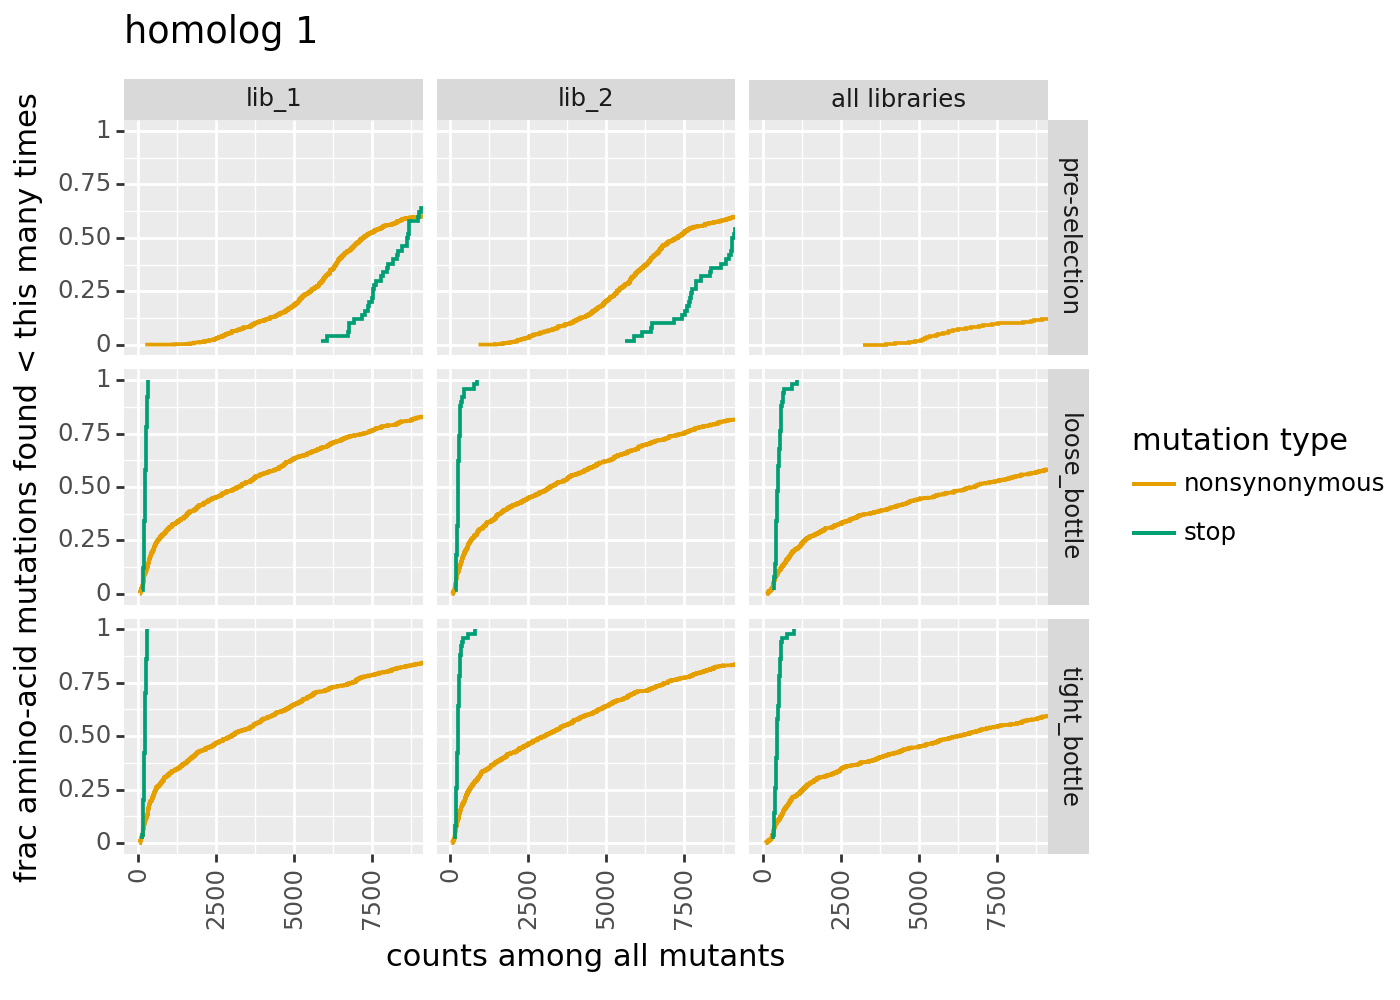

<Figure size 640x480 with 0 Axes>

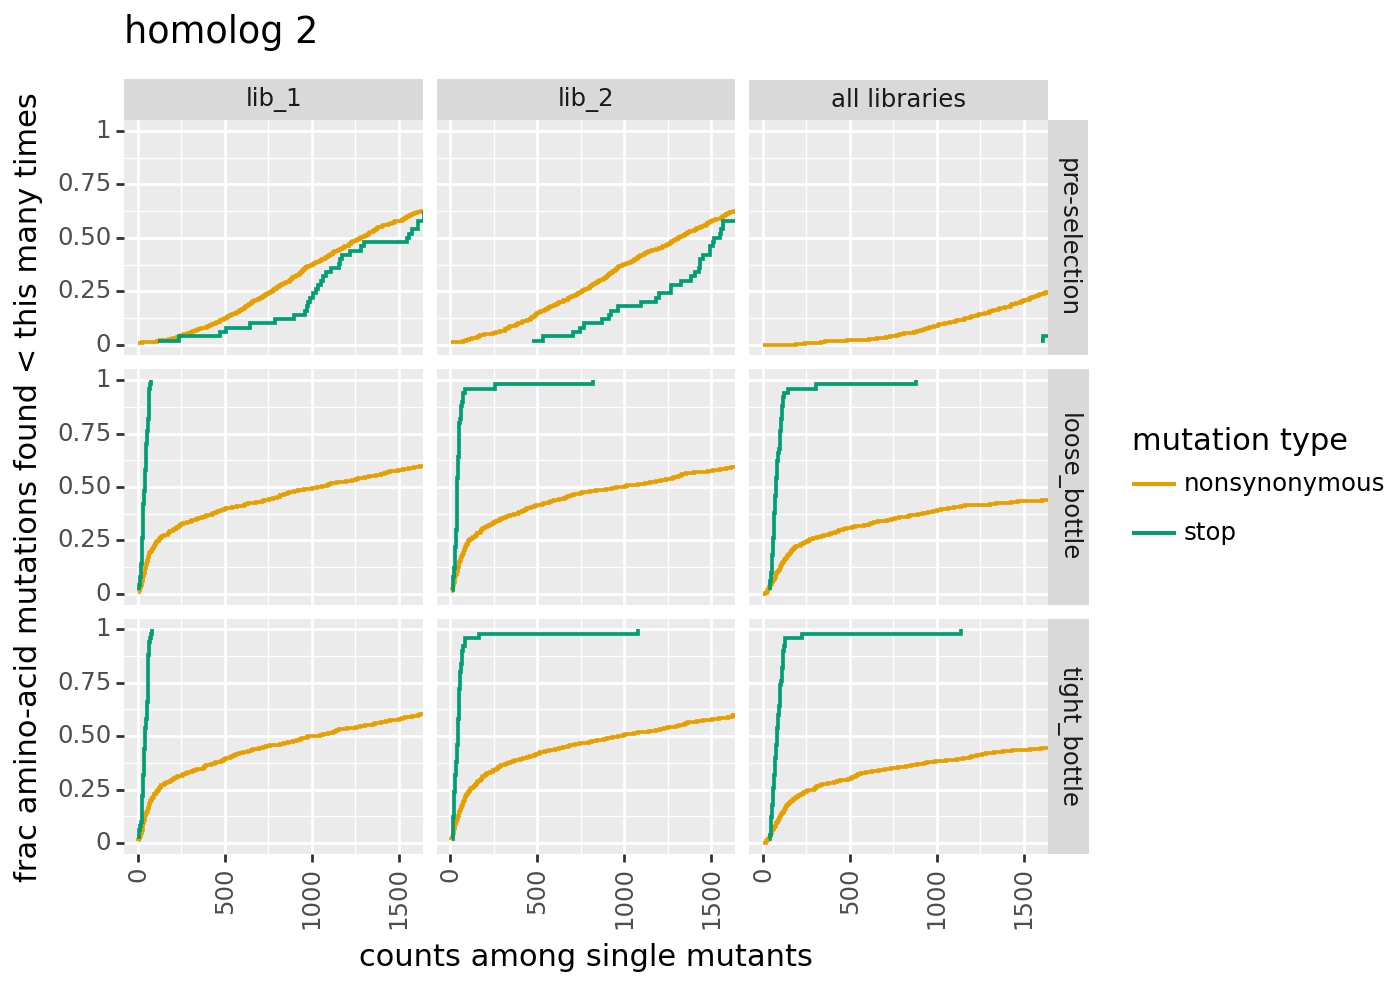

<Figure size 640x480 with 0 Axes>

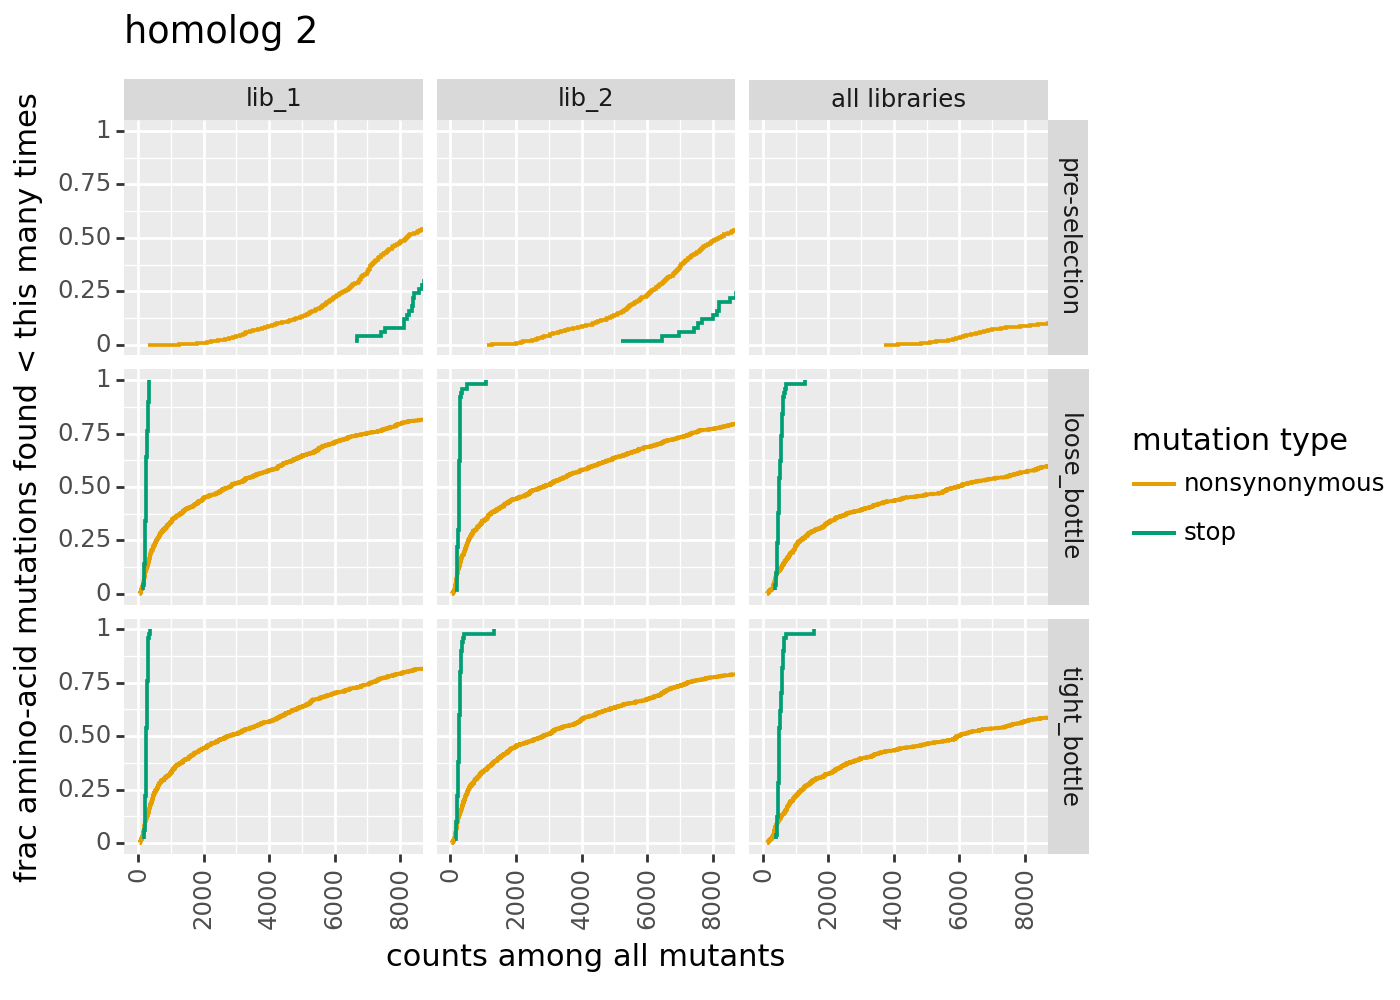

In [29]:
%matplotlib inline
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    for variant_type in ["single", "all"]:
        p = variants.plotCumulMutCoverage(variant_type=variant_type, mut_type="aa")
        p += labs(title=title)
        p += theme(figure_size=(7, 5))
        plt.tight_layout()
        _ = p.draw(show=True)

### Prep training data

Next, we will prepare the training data for fitting our joint `multidms` models.

In [30]:
# <!-- Start by creating training data with ground truth phenotype target. Because the barcode replicates share ground truth phenotypes we can can collapse the counts accross replicates by simple dropping duplicates. -->
# define the required columns and their order
req_cols = ["library", "condition", "aa_substitutions", "func_score_type", "func_score"]
ground_truth_training_set = (
    pd.concat(
        [
            variants.barcode_variant_df[["library", "aa_substitutions", "observed_enrichment", "observed_phenotype"]]
            .drop_duplicates()
            .assign(condition=homolog)
            for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
        ]
    )
    .melt(
        id_vars=["library", "aa_substitutions", "condition"],
        value_vars=["observed_enrichment", "observed_phenotype"],
        var_name="func_score_type",
        value_name="func_score",
    )
    [req_cols]
    .astype({c:str for c in req_cols[:-1]})
)
# Collapsing counts accross replicate `aa_substituitions` _before_ computing the functional score.
bottle_cbf = pd.concat(
    [
        (
            variants
            .func_scores("pre-selection", by="aa_substitutions", libraries=libs, syn_as_wt=True)
            .assign(condition=homolog)
            .rename({"post_sample":"func_score_type"}, axis=1)
            [req_cols]
            .astype({c:str for c in req_cols[:-1]})
        )
        for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
    ]
)

def classify_variant(aa_subs):
    if "*" in aa_subs:
        return "stop"
    elif aa_subs == "":
        return "wildtype"
    elif len(aa_subs.split()) == 1:
        return "1 nonsynonymous"
    elif len(aa_subs.split()) > 1:
        return ">1 nonsynonymous"
    else:
        raise ValueError(f"unexpected aa_subs: {aa_subs}")

func_scores = (
    pd.concat([ground_truth_training_set, bottle_cbf])
    .assign(variant_class = lambda x: x['aa_substitutions'].apply(classify_variant))
)

print(func_scores.groupby(["library", "func_score_type"]).size(), "\n")
func_scores.head()

library  func_score_type    
lib_1    loose_bottle           30281
         observed_enrichment    30281
         observed_phenotype     30281
         tight_bottle           30281
lib_2    loose_bottle           30263
         observed_enrichment    30263
         observed_phenotype     30263
         tight_bottle           30263
dtype: int64 



library condition                         aa_substitutions  \
0   lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1   lib_1        h1                       V8P H27T P30* L49P   
2   lib_1        h1                                V19P V43Q   
3   lib_1        h1                                     R20Y   
4   lib_1        h1                                            

       func_score_type  func_score     variant_class  
0  observed_enrichment    0.010000  >1 nonsynonymous  
1  observed_enrichment    0.010000              stop  
2  observed_enrichment    0.010142  >1 nonsynonymous  
3  observed_enrichment    0.952440   1 nonsynonymous  
4  observed_enrichment    1.000000          wildtype

Plot a pairplot to see how targets compare.

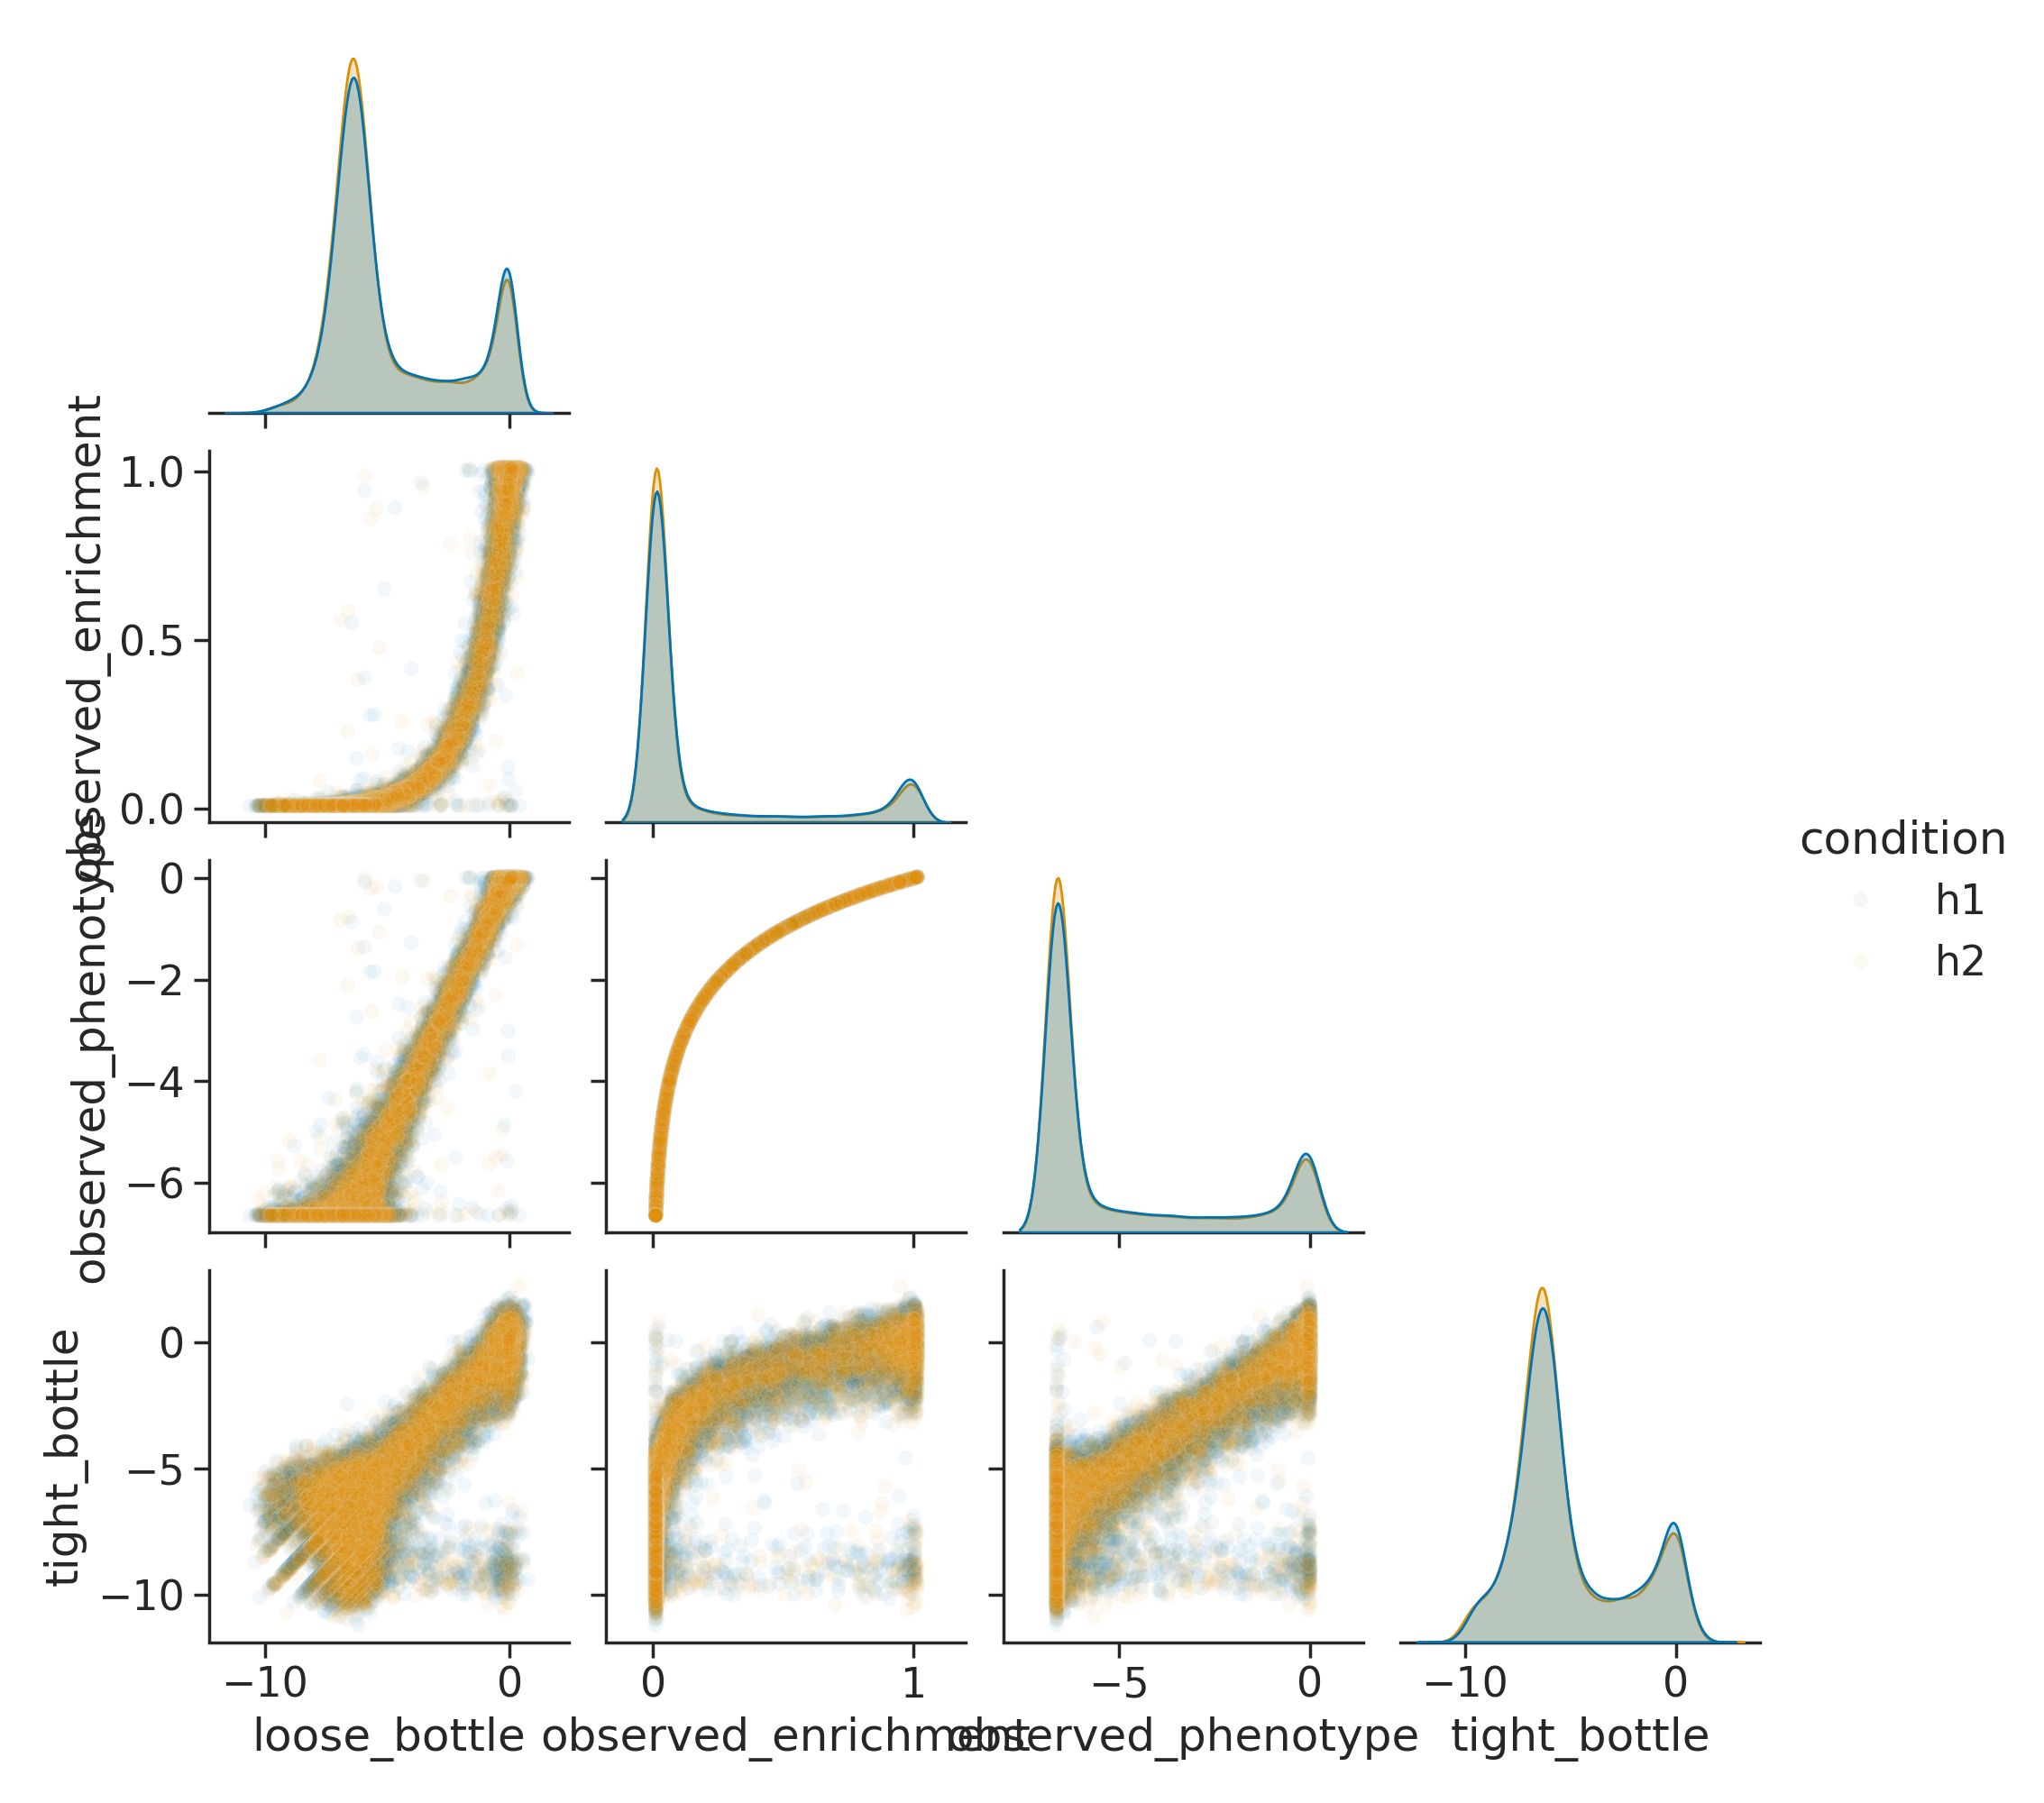

In [31]:
sns.pairplot(
    (
        func_scores
        .pivot(
            index=["library", "condition", "aa_substitutions", "variant_class"],
            columns="func_score_type",
            values="func_score"
        )
        .reset_index()
    ),  
    hue='condition',
    plot_kws = {"alpha":0.05},
    corner=True
)

Plot the functional scores distributions of the bottleneck counts-computed functional scores.

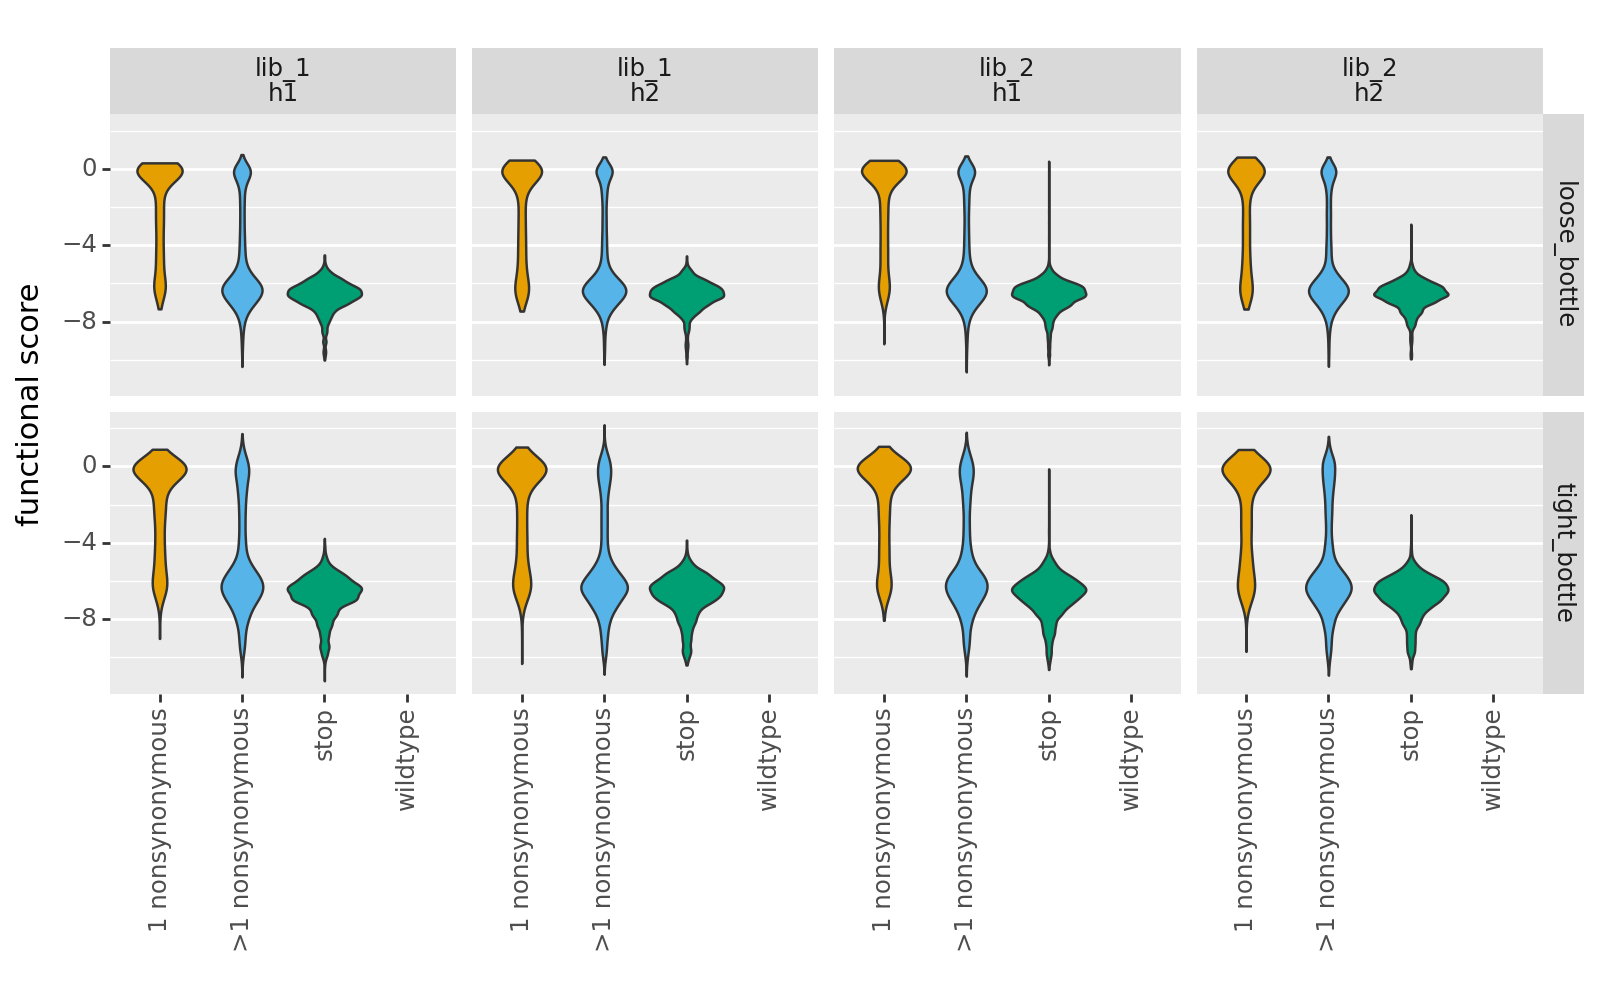

In [32]:
# for func_scores, title in zip([func_scores_h1, func_scores_h2], ['homolog 1', 'homolog 2']):
# for title, df in func_scores.group
p = (
    ggplot(
        func_scores.query("(func_score_type != 'observed_phenotype') & (func_score_type != 'observed_enrichment')"), 
        aes("variant_class", "func_score")
    )
    + geom_violin(aes(fill="variant_class"))
    + ylab("functional score")
    + xlab("")
    + facet_grid("func_score_type ~ library + condition")
    + theme(
        # figure_size=(3.75 * len(libs), 1.4 * len(func_scores["func_score_type"].unique())),
        figure_size=(8, 5),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + scale_fill_manual(values=CBPALETTE[1:], guide=False)
    # + labs(title=title)
)
_ = p.draw(show=True)

## 3. `multidms` Modeling

### Create `Data` objects for each library replicate, and bottleneck

In [80]:
data_objects = [
    multidms.Data(
        fs_df, 
        reference="h1", 
        alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
        verbose=True,
        name = f"{lib}_{target}_func_score"
    )
    for (lib, target), fs_df in func_scores.groupby(['library', 'func_score_type'])
    if "enrichment" not in target
]


inferring site map for h1


  0%|          | 0/15096 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15185 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15096 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15185 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15096 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15185 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15086 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15177 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15086 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15177 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15086 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15177 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


We now have the following datasets to fit to:

In [81]:
data_objects

[Data(lib_1_loose_bottle_func_score),
 Data(lib_1_observed_phenotype_func_score),
 Data(lib_1_tight_bottle_func_score),
 Data(lib_2_loose_bottle_func_score),
 Data(lib_2_observed_phenotype_func_score),
 Data(lib_2_tight_bottle_func_score)]

### Fit models across a range of regularization strengths

Create data fitting objects for each of the library replicates. We do this by grabbing the corect functional scores slices, and feeding them into the `multidms.Data` constructor. Note that we will not be fitting to the enrichment ground truth scores as those are simply the exponential of the phenotype.

Next, we'll fit a set of models to each of the datasets, across a sweep of lasso regularization coefficients using `multidms.fit_models`.

In [82]:
model_collection_params = {
    "dataset": data_objects,

    "num_training_steps" : [1],
    "iterations_per_step": [10000], # default 20000

    "scale_coeff_lasso_shift": [0.0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 3e-4],
    # "scale_coeff_lasso_shift": [2e-5],

    "init_beta_naught" : [5.0],
    # "alpha_d" : [True, False],

    "scale_coeff_ridge_beta" : [0.0], # we've found that a small ridge penalty is really quite helpful for the model to not get stuck at weird local minima
}
_, _, fit_collection = multidms.model_collection.fit_models(model_collection_params, n_threads=24)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun 

We now have a dataframe where each row contains a model and the hyperparamers that fit it. We'll add a few helpful features to this dataframe for plotting, and take a look at the models.

In [83]:
fit_collection["infer_beta_naught"] = [round(float(row.model.params['beta_naught'][0]), 2) for _, row in fit_collection.iterrows()]
fit_collection["measurement_type"] = fit_collection["dataset_name"].str.split("_").str[2:4].str.join("_")
fit_collection["library"] = fit_collection["dataset_name"].str.split("_").str[0:2].str.join("_")
# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
fit_collection["measurement_type"] = pd.Categorical(
    fit_collection["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
fit_collection.head()

model                   dataset_name  \
0  Model(Model-0)  lib_1_loose_bottle_func_score   
1  Model(Model-0)  lib_1_loose_bottle_func_score   
2  Model(Model-0)  lib_1_loose_bottle_func_score   
3  Model(Model-0)  lib_1_loose_bottle_func_score   
4  Model(Model-0)  lib_1_loose_bottle_func_score   

                                  step_loss epistatic_model output_activation  \
0   [8.948822093580924, 0.3406847473713822]         Sigmoid          Identity   
1   [8.948822093580924, 0.3411181864572774]         Sigmoid          Identity   
2  [8.948822093580924, 0.34174995208293235]         Sigmoid          Identity   
3  [8.948822093580924, 0.34344365710157143]         Sigmoid          Identity   
4   [8.948822093580924, 0.3456776136156477]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                     0.0                    0.0                       0   
1                 0.00001                    0.0                       0   
2                 0.00002                    0.0                       0   
3                 0.00005                    0.0                       0   
4                  0.0001                    0.0                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ... lock_beta_naught_at  \
0                       0                         0  ...                None   
1                       0                         0  ...                None   
2                       0                         0  ...                None   
3                       0                         0  ...                None   
4                       0                         0  ...                None   

      tol num_training_steps iterations_per_step n_hidden_units lower_bound  \
0  0.0001                  1               10000              5        None   
1  0.0001                  1               10000              5        None   
2  0.0001                  1               10000              5        None   
3  0.0001                  1               10000              5        None   
4  0.0001                  1               10000              5        None   

  PRNGKey infer_beta_naught measurement_type library  
0       0              5.52     loose_bottle   lib_1  
1       0              5.52     loose_bottle   lib_1  
2       0              5.51     loose_bottle   lib_1  
3       0              5.47     loose_bottle   lib_1  
4       0              5.42     loose_bottle   lib_1  

[5 rows x 24 columns]

First, let's grab the model predictions of latent, and observed phenotypes for each of the datasets using `multidms.Model.get_variants_df`. We'll then merge those predictions with the simulated ground truth so that we might compute correlation statistics for each model.


In [84]:

variants_df = pd.concat(
    [
        row.model.get_variants_df(phenotype_as_effect=True)
        .assign(
            # library="_".join(row.dataset_name.split("_")[0:2]),
            library=row.library,
            # measurement_type="_".join(row.dataset_name.split("_")[2:]),
            measurement_type=row.measurement_type,
            lasso=row.scale_coeff_lasso_shift,
            ridge=row.scale_coeff_ridge_beta,
            alpha_d=row.alpha_d
        )
        .rename(
            {
                "predicted_func_score": "predicted_phenotype", # wt is zero-centered (as_effect=True)
                "predicted_latent": "predicted_latent_phenotype",
                "func_score" : "measured_phenotype",
            },
            axis=1,
        )
        # add enrichments
        .assign(
            predicted_enrichment = lambda x: 2**x['predicted_phenotype'],
            measured_enrichment = lambda x: 2**x['measured_phenotype'],
            fit_idx = idx
        )
        for idx, row in fit_collection.iterrows()
    ]
)
variants_df.head()

condition aa_substitutions  measured_phenotype     var_wrt_ref  \
0        h1             Q28P           -0.258227            Q28P   
1        h1             G50E            0.075144            G50E   
2        h1             R48G           -2.659408            R48G   
3        h1    S3R G10Y L49H           -6.577912   S3R G10Y L49H   
4        h1   F18T Q21E C44T           -6.193633  F18T Q21E C44T   

   predicted_latent_phenotype  predicted_phenotype library measurement_type  \
0                   -2.515093            -0.287523   lib_1     loose_bottle   
1                   -1.131136            -0.055044   lib_1     loose_bottle   
2                   -5.147935            -2.686843   lib_1     loose_bottle   
3                  -13.175876            -6.614202   lib_1     loose_bottle   
4                  -12.356171            -6.610221   lib_1     loose_bottle   

   lasso  ridge  alpha_d  predicted_enrichment  measured_enrichment  fit_idx  
0    0.0    0.0    False              0.819308             0.836115        0  
1    0.0    0.0    False              0.962565             1.053466        0  
2    0.0    0.0    False              0.155303             0.158285        0  
3    0.0    0.0    False              0.010208             0.010468        0  
4    0.0    0.0    False              0.010236             0.013663        0

In [85]:

Latent_funcs = {
    "h1" : SigmoidPhenotype_h1.latentPhenotype,
    "h2" : SigmoidPhenotype_h2.latentPhenotype
}

Observed_funcs = {
    "h1" : SigmoidPhenotype_h1.observedPhenotype,
    "h2" : SigmoidPhenotype_h2.observedPhenotype
}

Enrichment_funcs = {
    "h1" : SigmoidPhenotype_h1.observedEnrichment,
    "h2" : SigmoidPhenotype_h2.observedEnrichment
}

variants_df  = pd.concat(
    [
        variants_df.query("condition == @homolog")
        .assign(
            true_latent_phenotype = lambda x: x['aa_substitutions'].map(Latent_funcs[homolog]),
            true_observed_phenotype = lambda x: x['aa_substitutions'].map(Observed_funcs[homolog]),
            true_enrichment = lambda x: x['aa_substitutions'].map(Enrichment_funcs[homolog]),
        )
        for homolog in ['h1', 'h2']
    ]
)

cols = [
    # unique combinations of these make up the model collection that we've fit
    "library", # replicate library,
    "measurement_type", # type of functional score
    "lasso", # lasso coefficient of model

    # variant defining columns
    "aa_substitutions", # variant substitutions
    "var_wrt_ref", # variant substitutions relative to reference
    "condition", # homolog

    "measured_phenotype", # the actual target functional score for training, in multidms, this is "func_score"
    "measured_enrichment", # 2 ** measured_func_score

    "predicted_latent_phenotype", # predicted latent phenotype
    "predicted_phenotype", # predicted observed phenotype - or in jesse's case, the "observed phenotype"
    "predicted_enrichment", # predicted enrichment

    "true_latent_phenotype", # true latent phenotype
    "true_observed_phenotype", # true observed phenotype
    "true_enrichment", # true enrichment
]
variants_df[cols].round(2).head()


library measurement_type  lasso aa_substitutions     var_wrt_ref condition  \
0   lib_1     loose_bottle    0.0             Q28P            Q28P        h1   
1   lib_1     loose_bottle    0.0             G50E            G50E        h1   
2   lib_1     loose_bottle    0.0             R48G            R48G        h1   
3   lib_1     loose_bottle    0.0    S3R G10Y L49H   S3R G10Y L49H        h1   
4   lib_1     loose_bottle    0.0   F18T Q21E C44T  F18T Q21E C44T        h1   

   measured_phenotype  measured_enrichment  predicted_latent_phenotype  \
0               -0.26                 0.84                       -2.52   
1                0.08                 1.05                       -1.13   
2               -2.66                 0.16                       -5.15   
3               -6.58                 0.01                      -13.18   
4               -6.19                 0.01                      -12.36   

   predicted_phenotype  predicted_enrichment  true_latent_phenotype  \
0                -0.29                  0.82                   1.70   
1                -0.06                  0.96                   3.48   
2                -2.69                  0.16                  -1.72   
3                -6.61                  0.01                 -12.27   
4                -6.61                  0.01                 -10.81   

   true_observed_phenotype  true_enrichment  
0                    -0.23             0.85  
1                    -0.03             0.98  
2                    -2.63             0.16  
3                    -6.64             0.01  
4                    -6.64             0.01

In [86]:
fit_collection["variant_phenotype_corr"] = np.nan
for idx, model_variants_df in variants_df.groupby(["fit_idx"]):
    fit_collection.loc[idx, "variant_phenotype_corr"] = model_variants_df["predicted_phenotype"].corr(model_variants_df["measured_phenotype"])
fit_collection[["scale_coeff_lasso_shift", "dataset_name", "variant_phenotype_corr"]].head()

scale_coeff_lasso_shift                   dataset_name  \
0                     0.0  lib_1_loose_bottle_func_score   
1                 0.00001  lib_1_loose_bottle_func_score   
2                 0.00002  lib_1_loose_bottle_func_score   
3                 0.00005  lib_1_loose_bottle_func_score   
4                  0.0001  lib_1_loose_bottle_func_score   

   variant_phenotype_corr  
0                0.968988  
1                0.968946  
2                0.968890  
3                0.968742  
4                0.968557

Get the mutational parameters for each of the models, and merge them with the simulated ground truth parameters

In [87]:
mutations_df = pd.concat(
    [
        row.model.get_mutations_df()
        .assign(
            library=row.library,
            measurement_type=row.measurement_type,
            lasso=row.scale_coeff_lasso_shift,
            fit_idx = idx,
            ridge=row.scale_coeff_ridge_beta,
            alpha_d=row.alpha_d
        )
        .rename(
            {
                'beta' : 'predicted_beta',
                'shift_h2' : 'predicted_shift_h2',
            }, 
            axis=1
        )    
        .merge(
            mut_effects_df.rename(
                {
                    'beta_h1' : 'true_beta',
                    'beta_h2' : 'true_beta_h2',
                    'shift' : 'true_shift',
                },
                axis=1
            ),
            on='mutation'
        )
        for idx, row in fit_collection.iterrows()
    ]
)
mutations_df.head()

mutation  predicted_beta  predicted_shift_h2  predicted_func_score_h1  \
0      G1A       -4.419521            0.083605                -1.633964   
1      G1C       -6.715044           -1.008357                -5.075354   
2      G1D       -1.015190            0.180360                -0.046209   
3      G1E       -6.639006            0.268366                -4.983490   
4      G1F       -1.032853            0.038793                -0.047492   

   predicted_func_score_h2  times_seen_h1  times_seen_h2 wts  sites muts  ...  \
0                -1.515895             47             47   G      1    A  ...   
1                -5.941396             30             30   G      1    C  ...   
2                -0.018182             20             20   G      1    D  ...   
3                -4.614790             37             37   G      1    E  ...   
4                -0.028574             25             25   G      1    F  ...   

  alpha_d true_beta  wt_aa  site  mut_aa  shifted_site  true_shift  \
0   False -5.811474      G     1       A         False         0.0   
1   False -8.878036      G     1       C         False         0.0   
2   False -1.013877      G     1       D         False         0.0   
3   False -8.349956      G     1       E         False         0.0   
4   False -1.349155      G     1       F         False         0.0   

  true_beta_h2  aaseq_h1 aaseq_h2  
0    -5.811474         G        G  
1    -8.878036         G        G  
2    -1.013877         G        G  
3    -8.349956         G        G  
4    -1.349155         G        G  

[5 rows x 25 columns]

Add correlation of predicted and true beta, and predicted and true shift to the fit collection dataframe

In [88]:
fit_collection["beta_corr"] = np.nan
fit_collection["shift_corr"] = np.nan
for idx, model_mutations_df in mutations_df.groupby(["fit_idx"]):
    fit_collection.loc[idx, "beta_corr"] = model_mutations_df["predicted_beta"].corr(model_mutations_df["true_beta"])
    fit_collection.loc[idx, "shift_corr"] = model_mutations_df["predicted_shift_h2"].corr(model_mutations_df["true_shift"])

### Predicted vs. Simulated Ground Truth

Next, we'll make some summary plots with the predicted vs. simulated ground truth parameters across model fits



For the summary correlations plots, we'll subset our models to only compare models across

1. replicate libraries
2. measurement type
3. lasso coefficient

That is, we'll need to choose a subset of models that have the same

1. ridge coefficient on the beta parameters
2. existance of a conditional latent offset parameter, "alpha_d"

In [89]:
subset = "(scale_coeff_ridge_beta == 0) & (alpha_d == False)"

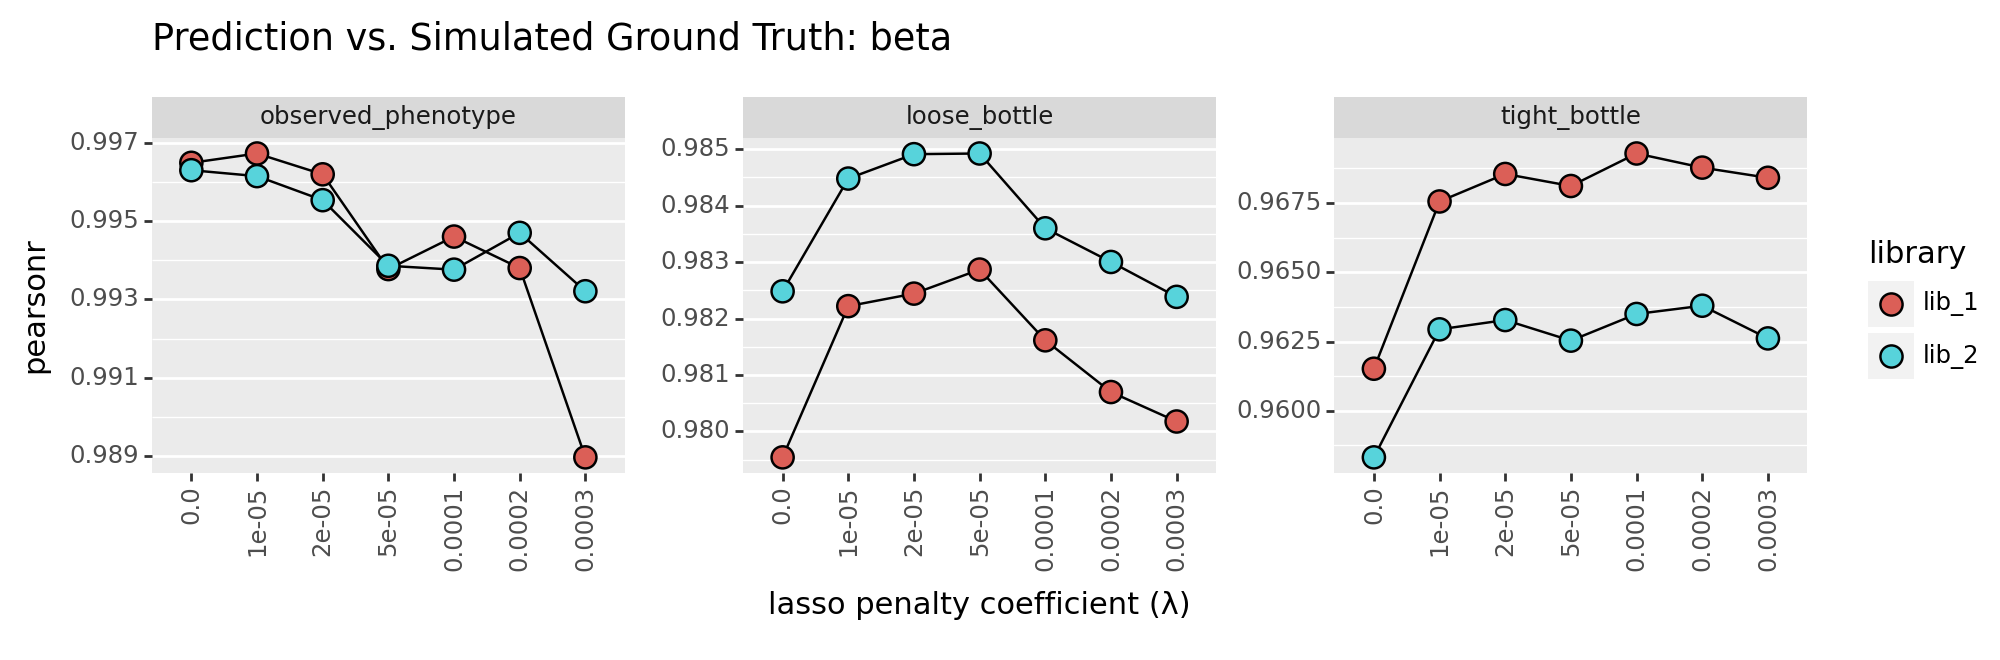

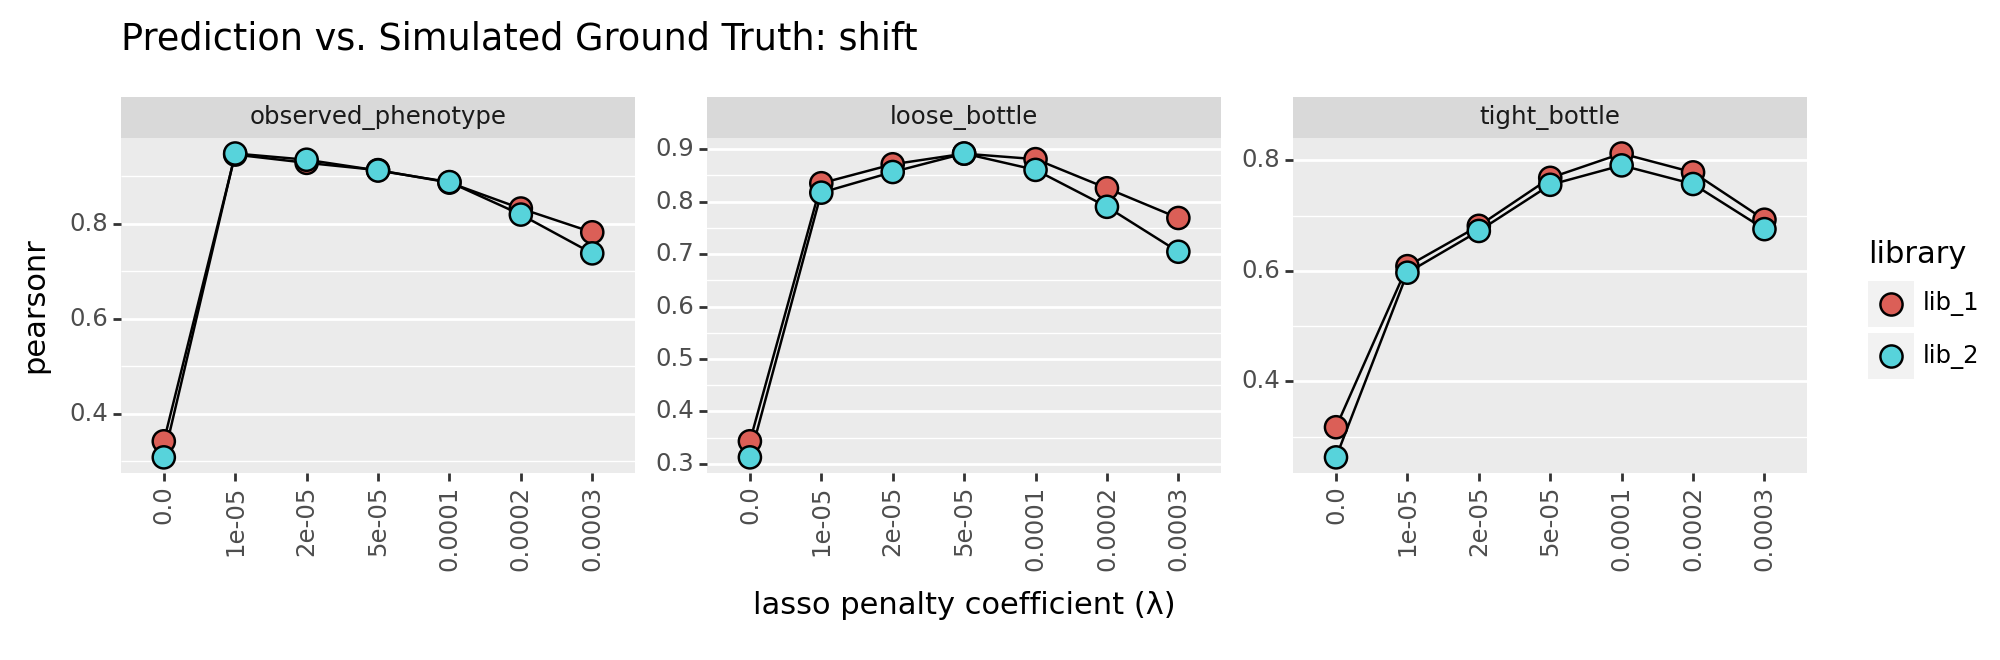

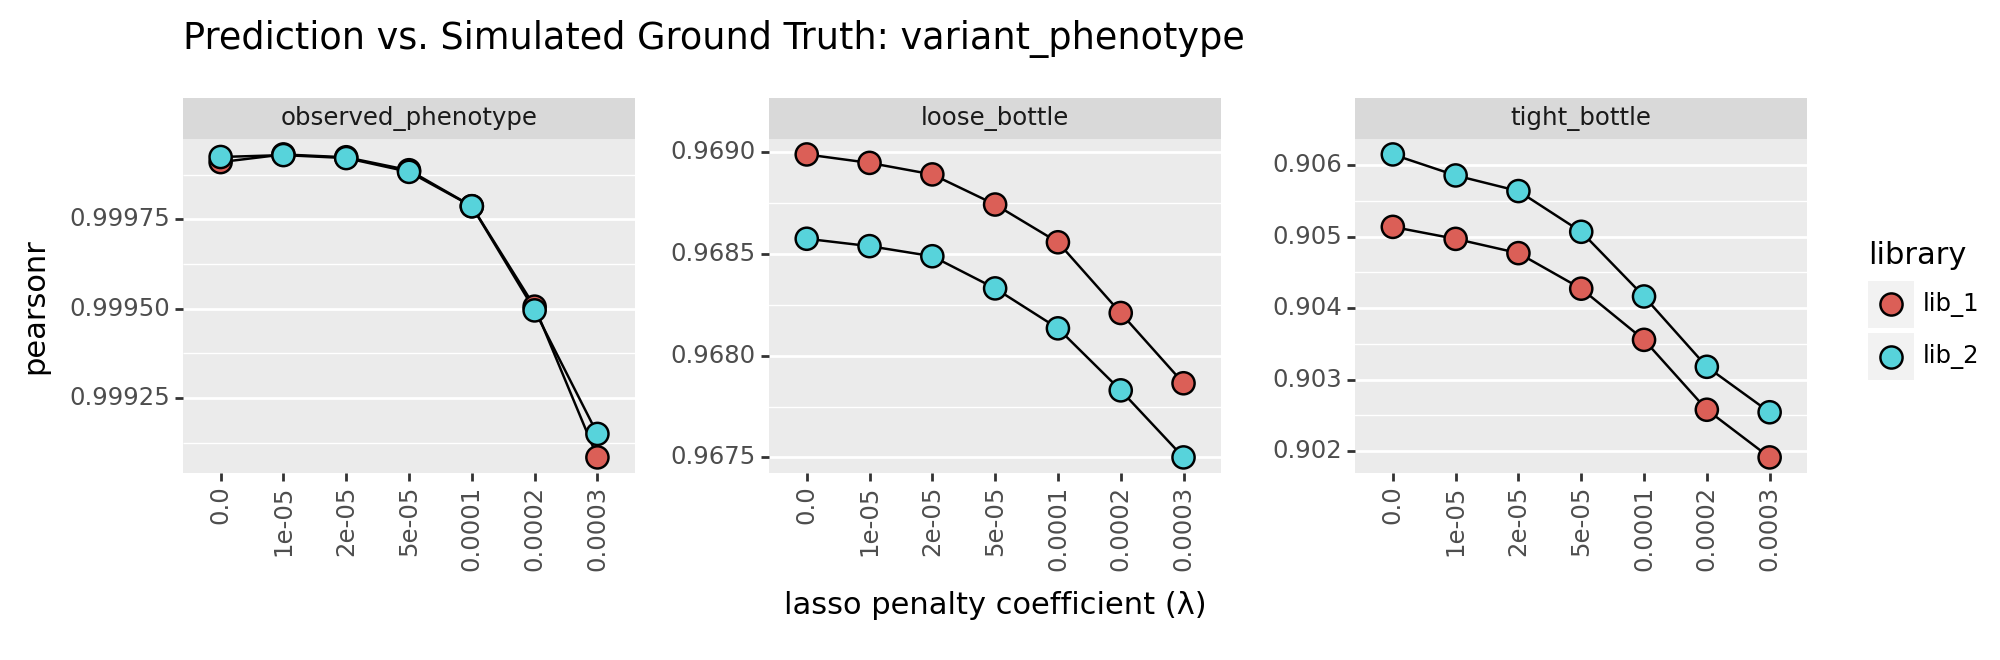

In [90]:
data = (
    fit_collection
    .query(subset)
    .assign(
        measurement_library = lambda x: x["measurement_type"].astype(str) + " " + x["library"]
    )
    .melt(
        id_vars=["scale_coeff_lasso_shift", "library", "measurement_type", "measurement_library"],
        value_vars=["beta_corr", "shift_corr", "variant_phenotype_corr"],
        var_name="parameter",
        value_name="correlation",
    )
)
data["parameter"] = data["parameter"].str.replace("_corr", "")
data["parameter"] = pd.Categorical(
    data["parameter"],
    categories=["beta", "shift", "variant_phenotype"],
    ordered=True
)
for parameter, parameter_df in data.groupby("parameter"):
    p = (
        ggplot(parameter_df)
        + geom_line(
            aes(
                x="scale_coeff_lasso_shift",
                y=f"correlation",
                group="measurement_library",
            ),
        )
        + geom_point(
            aes(
                x="scale_coeff_lasso_shift",
                y=f"correlation",
                fill="library",
                # shape="library"
            ),
            size=4
        )
        # + scale_y_continuous(limits=[0.9, 1])
        + facet_wrap("measurement_type", scales="free_y")
        + theme(
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
            panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        + labs(
            title=f"Prediction vs. Simulated Ground Truth: {parameter}",
            x="lasso penalty coefficient (λ)",
            y="pearsonr"
        )
    )
    _ = p.draw(show=True)

### Sparsity (TODO)

### Correlation of libraries

In [91]:
from scipy.stats import pearsonr
from collections import defaultdict

In [92]:
library_correlations = defaultdict(list)
for measurement_type, lasso in itertools.product(["observed_phenotype", "loose_bottle", "tight_bottle"], model_collection_params["scale_coeff_lasso_shift"]):
    query = f"(lasso == {lasso}) & (measurement_type == '{measurement_type}')"
    # get library replicate correlation of predicted beta, and shift from mutations_df subset
    library_correlations["measurement_type"].append(measurement_type)
    library_correlations["scale_coeff_lasso_shift"].append(lasso)

    # mutations dataframe
    wide_mutation_data = (
        mutations_df
        .query(query)
        [["mutation", "library", "predicted_beta", "predicted_shift_h2"]]
        .pivot_table(
            index=["mutation"],
            columns="library",
            values=["predicted_beta", "predicted_shift_h2"]
        )
    )
    library_correlations["beta"].append(wide_mutation_data["predicted_beta"].corr().iloc[0, 1])
    library_correlations["shift"].append(wide_mutation_data["predicted_shift_h2"].corr().iloc[0, 1])

    # now for the variants dataframe
    wide_variant_data = (
        variants_df
        .query(query)
        [["aa_substitutions", "library", "predicted_phenotype"]]
        .pivot_table(
            index=["aa_substitutions"],
            columns="library",
            values="predicted_phenotype"
        )
    )
    library_correlations["phenotype"].append(wide_variant_data.corr().iloc[0, 1])

library_correlations_df = pd.DataFrame(library_correlations)
library_correlations_df["scale_coeff_lasso_shift"] = library_correlations_df["scale_coeff_lasso_shift"].astype(object)
library_correlations_df["measurement_type"] = pd.Categorical(
    library_correlations_df["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
library_correlations_df

measurement_type scale_coeff_lasso_shift      beta     shift  phenotype
0   observed_phenotype                     0.0  0.997166  0.884744   0.999939
1   observed_phenotype                 0.00001  0.997490  0.981451   0.999970
2   observed_phenotype                 0.00002  0.997116  0.982636   0.999963
3   observed_phenotype                 0.00005  0.996199  0.983908   0.999950
4   observed_phenotype                  0.0001  0.996347  0.975076   0.999905
5   observed_phenotype                  0.0002  0.996510  0.959016   0.999833
6   observed_phenotype                  0.0003  0.993837  0.913298   0.999611
7         loose_bottle                     0.0  0.961787  0.573181   0.998695
8         loose_bottle                 0.00001  0.964316  0.760801   0.998842
9         loose_bottle                 0.00002  0.965349  0.839698   0.998930
10        loose_bottle                 0.00005  0.966523  0.935091   0.998996
11        loose_bottle                  0.0001  0.964369  0.952361   0.999004
12        loose_bottle                  0.0002  0.963013  0.917041   0.998871
13        loose_bottle                  0.0003  0.962052  0.875368   0.998720
14        tight_bottle                     0.0  0.924830  0.253579   0.994653
15        tight_bottle                 0.00001  0.935960  0.422863   0.995004
16        tight_bottle                 0.00002  0.937789  0.529749   0.995198
17        tight_bottle                 0.00005  0.938201  0.690395   0.995697
18        tight_bottle                  0.0001  0.940333  0.807143   0.996280
19        tight_bottle                  0.0002  0.939924  0.838304   0.996473
20        tight_bottle                  0.0003  0.939134  0.787788   0.996371

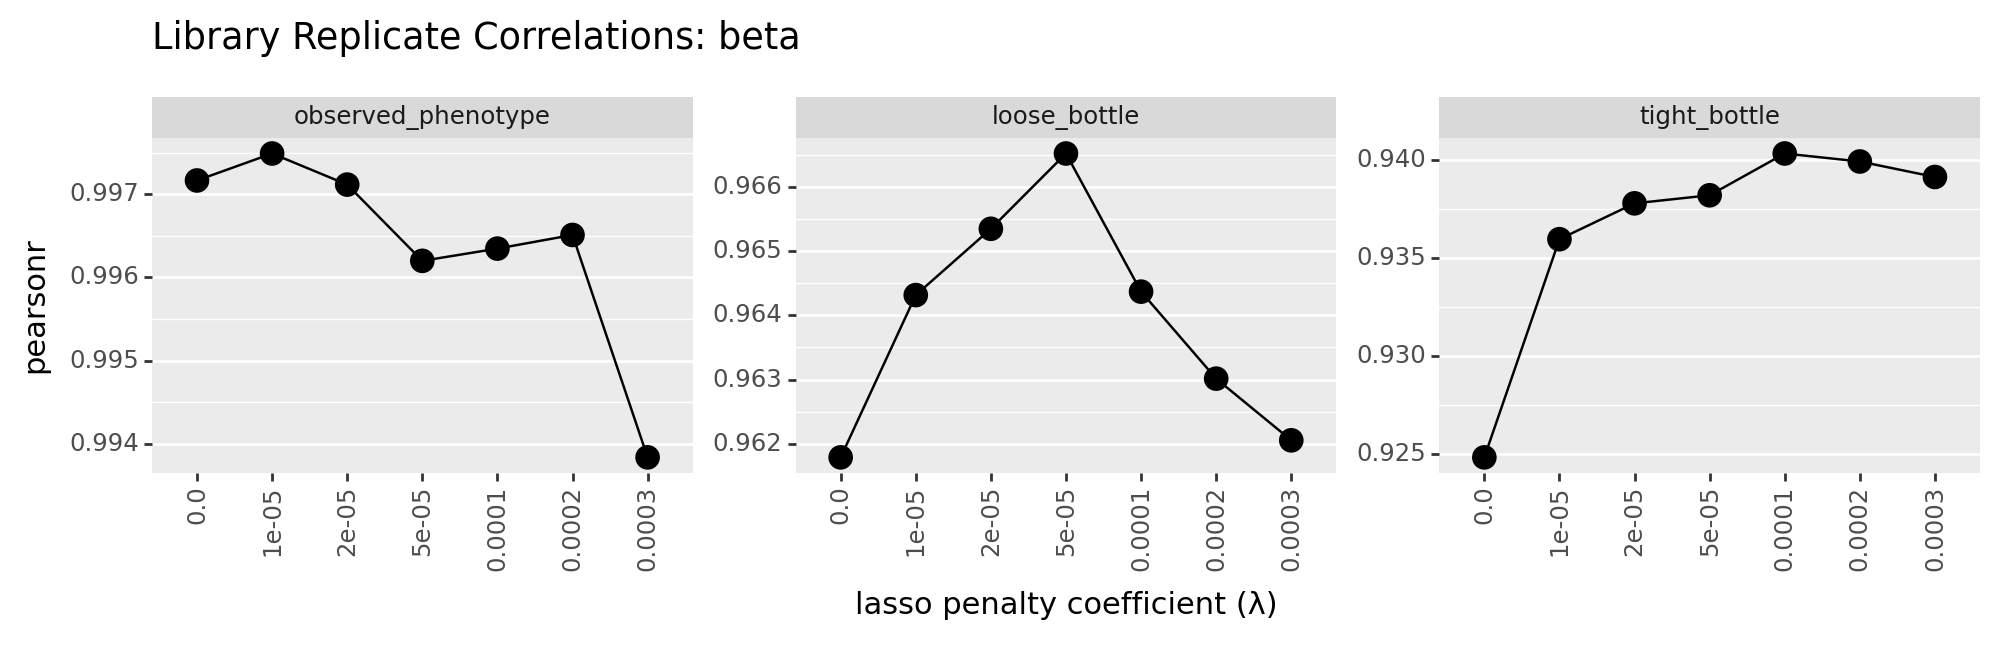

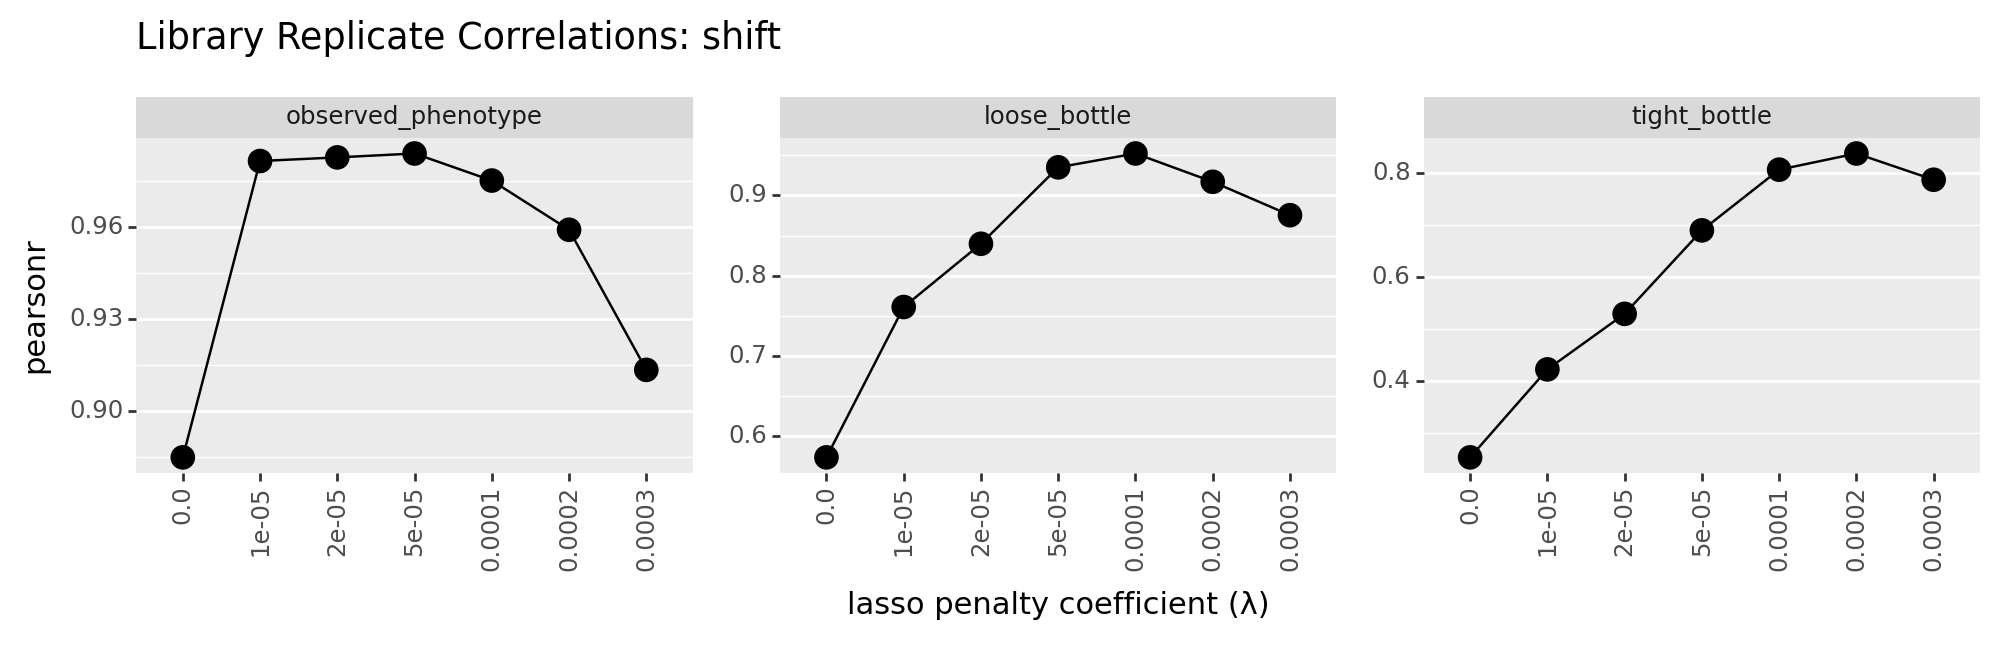

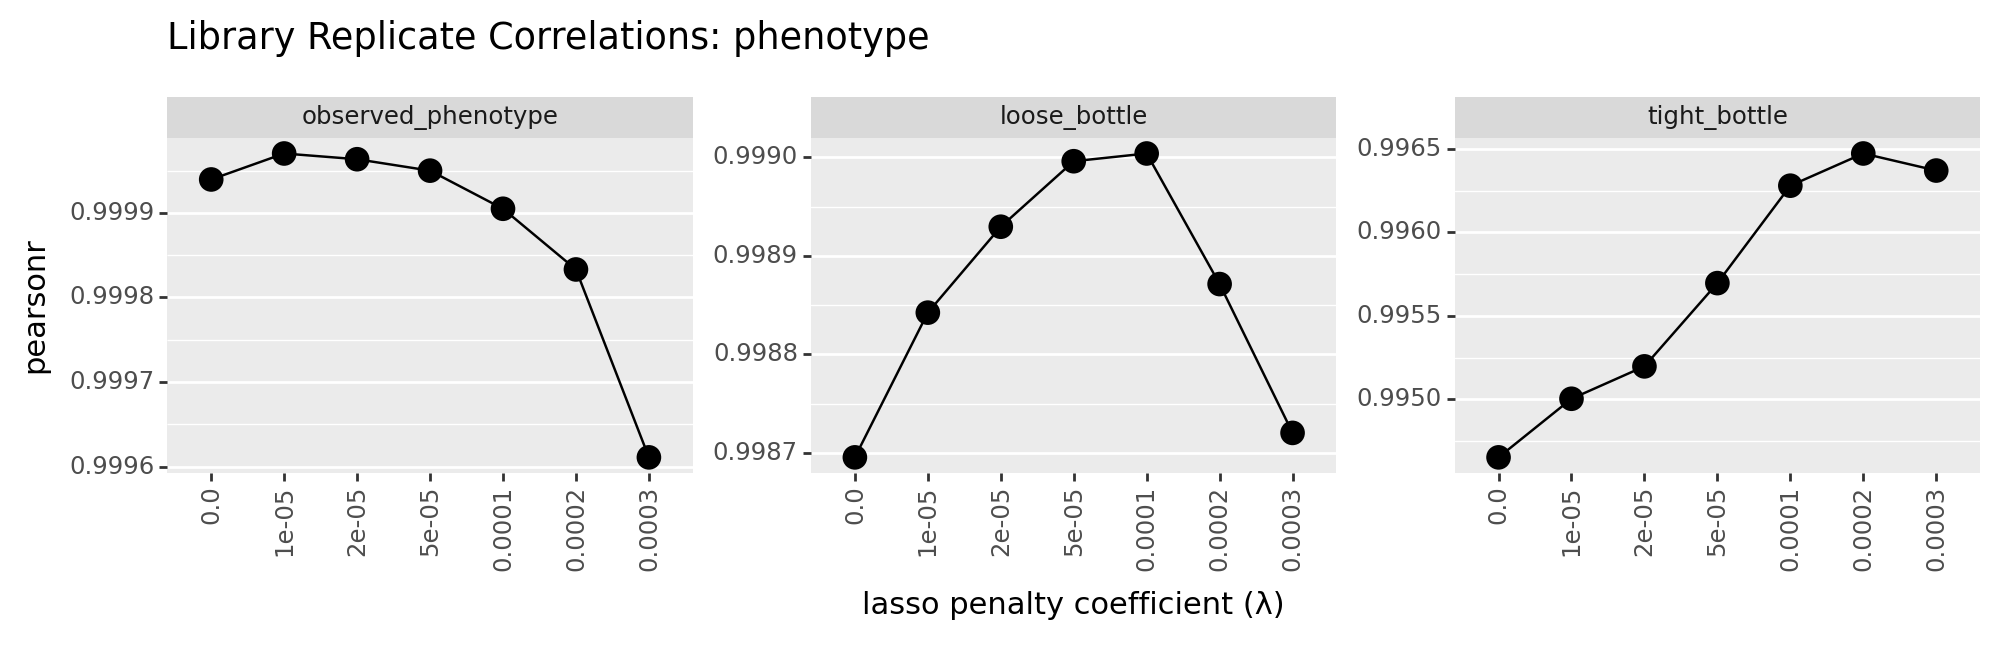

In [93]:
data = (
    library_correlations_df
    .melt(
        id_vars=["scale_coeff_lasso_shift", "measurement_type"],
        value_vars=["beta", "shift", "phenotype"],
        var_name="parameter",
        value_name="correlation"
    )
)
data["parameter"] = pd.Categorical(
    data["parameter"],
    categories=["beta", "shift", "phenotype"],
    ordered=True
)
for parameter, parameter_df in data.groupby("parameter"):
    p = (
        ggplot(
            parameter_df
        )
        + geom_line(
            aes(
                x="scale_coeff_lasso_shift",
                y="correlation",
                group="measurement_type"
            ),
        )
        + geom_point(
            aes(
                x="scale_coeff_lasso_shift",
                y="correlation",
                # fill="measurement_type"
            ),
            size=4
        )
        + facet_wrap("measurement_type", scales="free_y")
        + theme(
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
            panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        + labs(
            title=f"Library Replicate Correlations: {parameter}",
            x="lasso penalty coefficient (λ)",
            y="pearsonr"
        )
    )
    _ = p.draw(show=True)

### Singular Model Evaluation

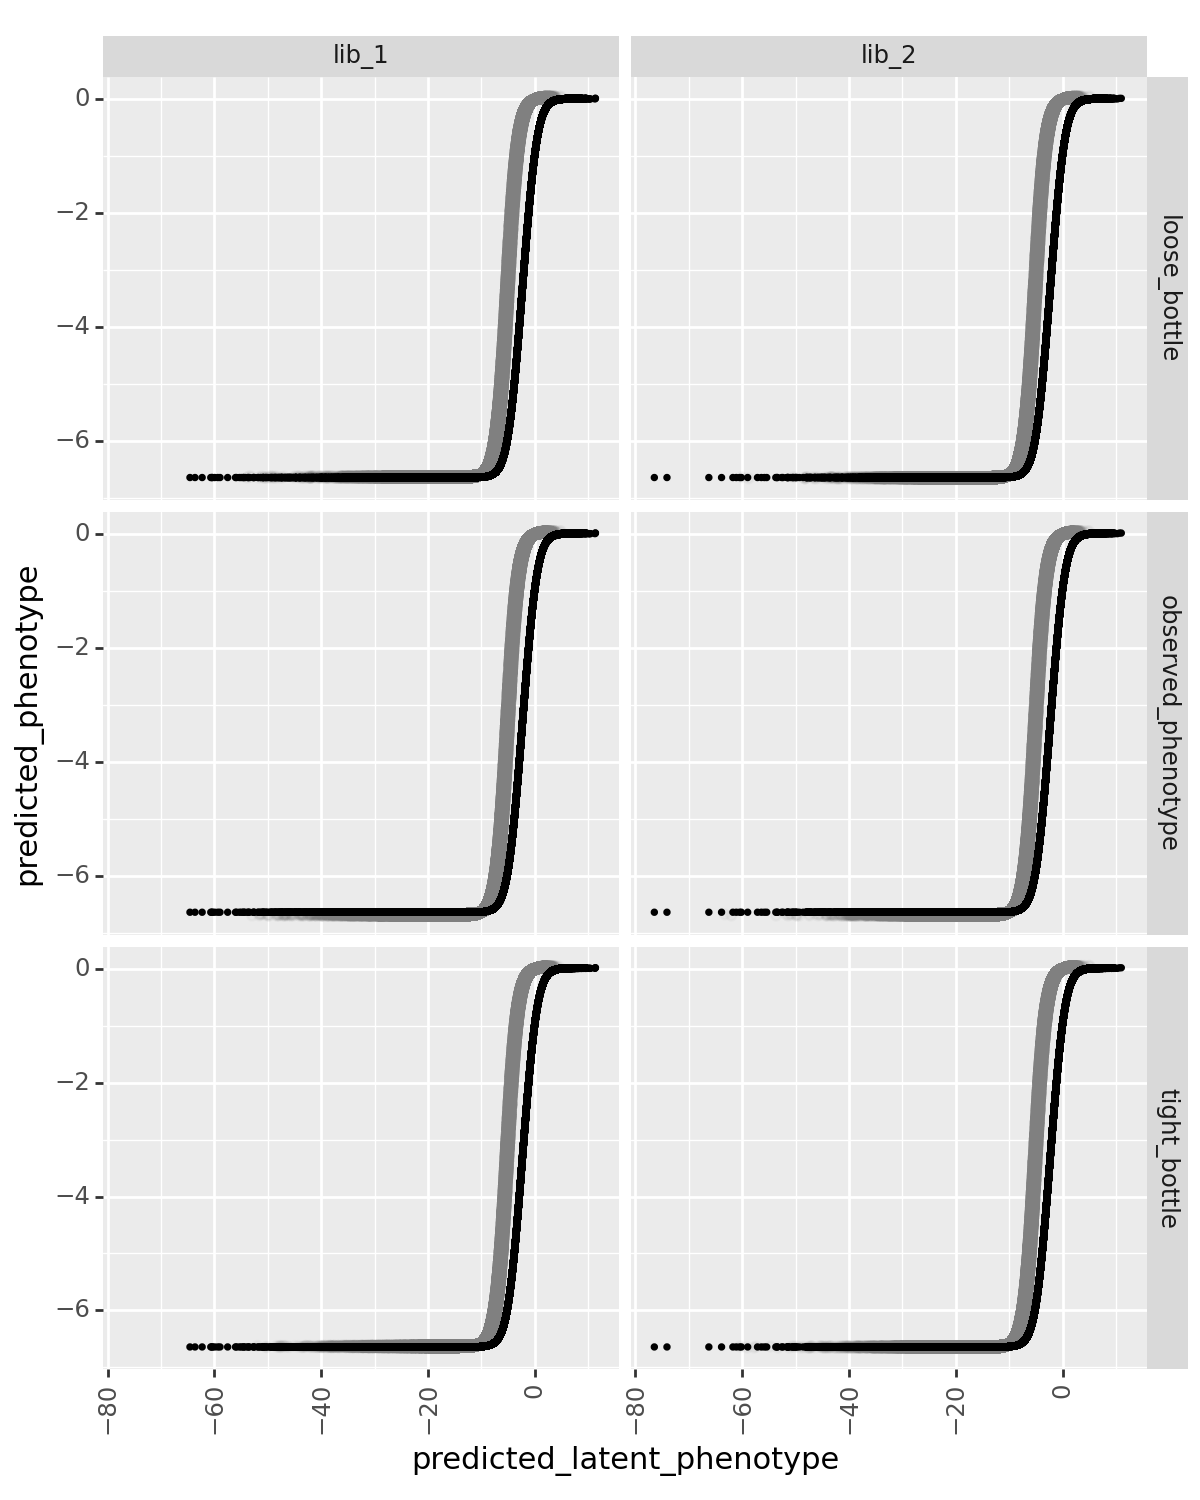

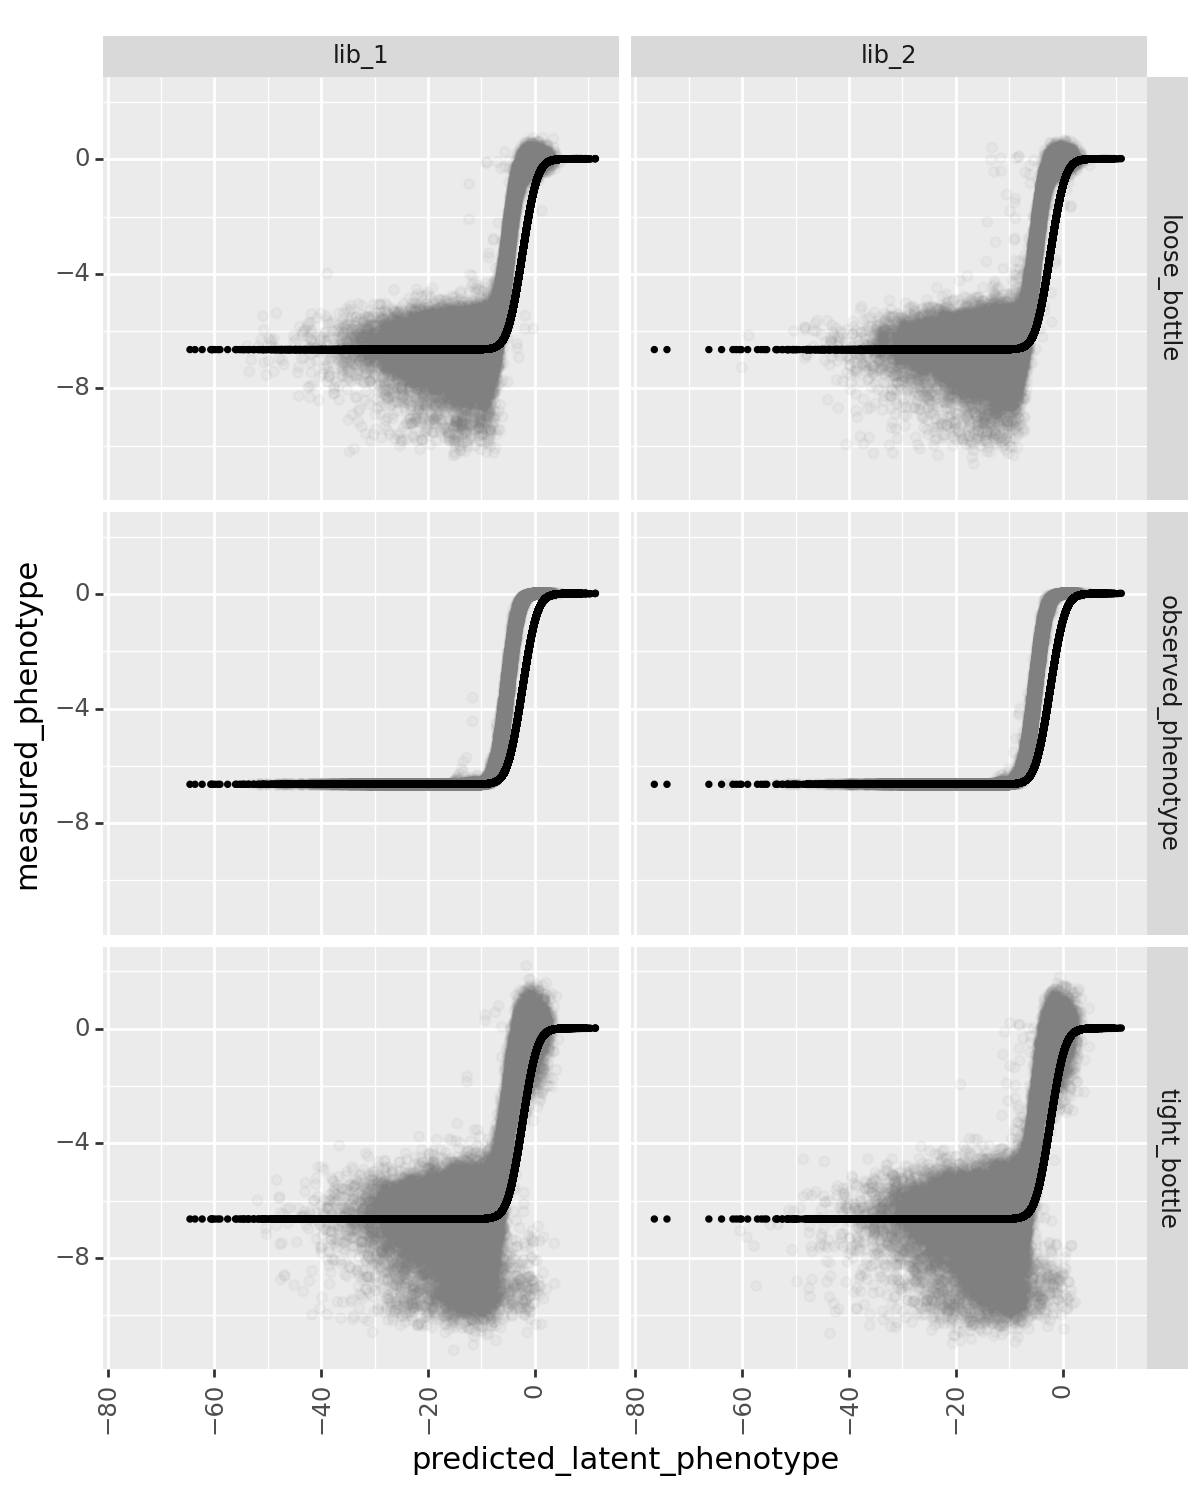

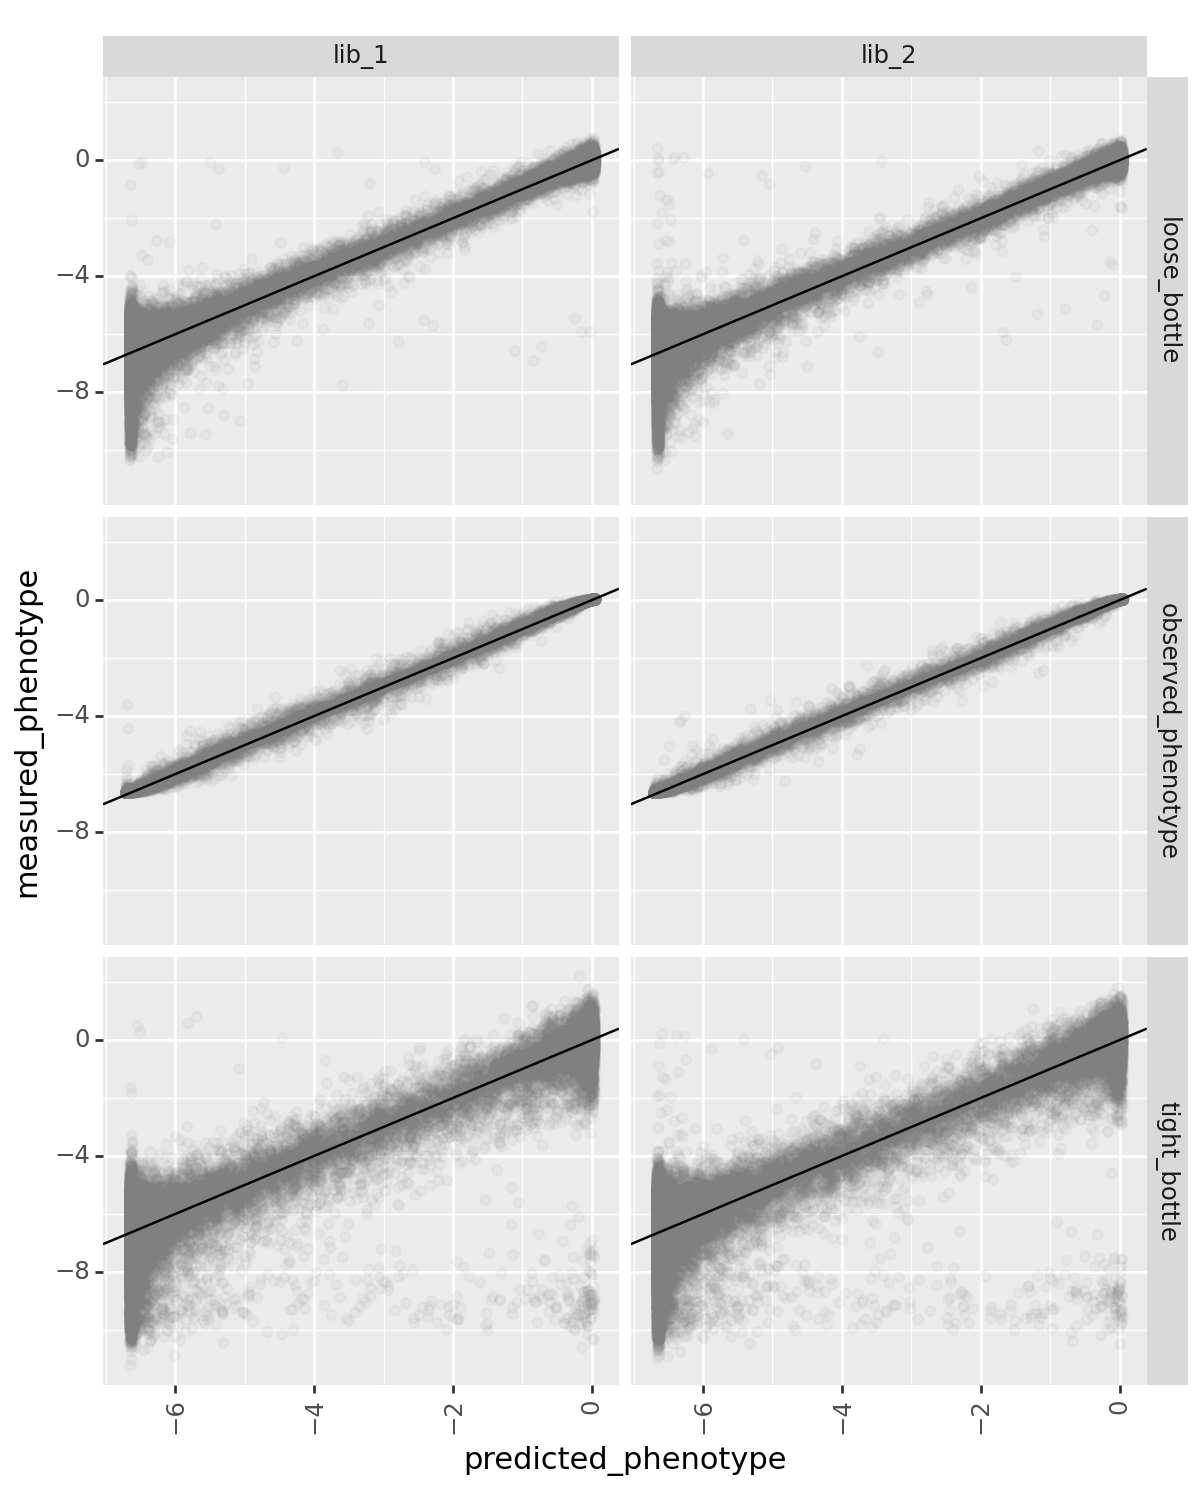

In [98]:
lasso = 3e-4
data = variants_df.query(f"lasso == {lasso}")
# for library, title in zip(["lib_1", "lib_2"], ["Library 1", "homolog 2"]):
for x, y in itertools.combinations(
    ["predicted_latent_phenotype", "predicted_phenotype", "measured_phenotype"], 2
):
    p = (
        ggplot(data.sample(frac=1.0))
        + geom_point(
            aes(
                # data=data,
                # fill="post_sample + library",
                x=x,
                y=y    
                # x="predicted_latent_phenotype",
                # y="predicted_phenotype"
            ),
            alpha=0.05,
            # size=0.5,
            color="grey"
        )
        # ground truth 
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(3 * len(libs), 2.5 * len(data["measurement_type"].unique())),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
        # + labs(title=title)
        # make point more alpha
        # + scale_alpha(0.01)
    )

    if x == "predicted_latent_phenotype":
        p+= geom_point(
            aes(
                # fill="post_sample + library",
                # x=x,
                # y=y    
                x="true_latent_phenotype",
                y="true_observed_phenotype"
            ),
            # alpha=0.05,
            size=0.5,
            # color="grey"
        )
    else:
        p += geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
            # size=0.5,
        )

    
        
    _ = p.draw(show=True)

Overall these look very similar to the simulated sigmoid. Note that both the homolog conditions share the same sigmoid, and there is no latent offset ($\alpha_d$) parameter in these models.

In [99]:
variants_df

condition     aa_substitutions  measured_phenotype  \
0            h1                 Q28P           -0.258227   
1            h1                 G50E            0.075144   
2            h1                 R48G           -2.659408   
3            h1        S3R G10Y L49H           -6.577912   
4            h1       F18T Q21E C44T           -6.193633   
...         ...                  ...                 ...   
30258        h2  V24P Q28L T36A G37A           -6.911844   
30259        h2            V19Y P30T           -6.714807   
30260        h2            V24S P30*           -5.057695   
30261        h2            V19L N46A           -0.909796   
30262        h2   P6R R20S T35S S47I           -6.311452   

                                             var_wrt_ref  \
0                                                   Q28P   
1                                                   G50E   
2                                                   R48G   
3                                          S3R G10Y L49H   
4                                         F18T Q21E C44T   
...                                                  ...   
30258  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30259  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30260  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30261  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30262  G6R G10C V11C V12S R13W S14W S25H Y38W T45G L4...   

       predicted_latent_phenotype  predicted_phenotype library  \
0                       -2.515093            -0.287523   lib_1   
1                       -1.131136            -0.055044   lib_1   
2                       -5.147935            -2.686843   lib_1   
3                      -13.175876            -6.614202   lib_1   
4                      -12.356171            -6.610221   lib_1   
...                           ...                  ...     ...   
30258                  -17.178141            -6.635092   lib_2   
30259                   -2.010207            -0.312062   lib_2   
30260                  -18.171975            -6.635111   lib_2   
30261                   -5.133328            -3.733822   lib_2   
30262                  -22.914981            -6.635122   lib_2   

      measurement_type  lasso  ridge  alpha_d  predicted_enrichment  \
0         loose_bottle    0.0    0.0    False              0.819308   
1         loose_bottle    0.0    0.0    False              0.962565   
2         loose_bottle    0.0    0.0    False              0.155303   
3         loose_bottle    0.0    0.0    False              0.010208   
4         loose_bottle    0.0    0.0    False              0.010236   
...                ...    ...    ...      ...                   ...   
30258     tight_bottle    0.0    0.0    False              0.010061   
30259     tight_bottle    0.0    0.0    False              0.805490   
30260     tight_bottle    0.0    0.0    False              0.010061   
30261     tight_bottle    0.0    0.0    False              0.075164   
30262     tight_bottle    0.0    0.0    False              0.010061   

       measured_enrichment  fit_idx  true_latent_phenotype  \
0                 0.836115        0               1.699359   
1                 1.053466        0               3.482279   
2                 0.158285        0              -1.715749   
3                 0.010468        0             -12.268278   
4                 0.013663        0             -10.810320   
...                    ...      ...                    ...   
30258             0.008305       41             -19.181708   
30259             0.009520       41               1.801738   
30260             0.030025       41             -12.848723   
30261             0.532260       41              -2.460109   
30262             0.012591       41             -25.785319   

       true_observed_phenotype  true_enrichment  
0                    -0.229998         0.852636  
1                    -0.033645         0.976949  
2                    -2

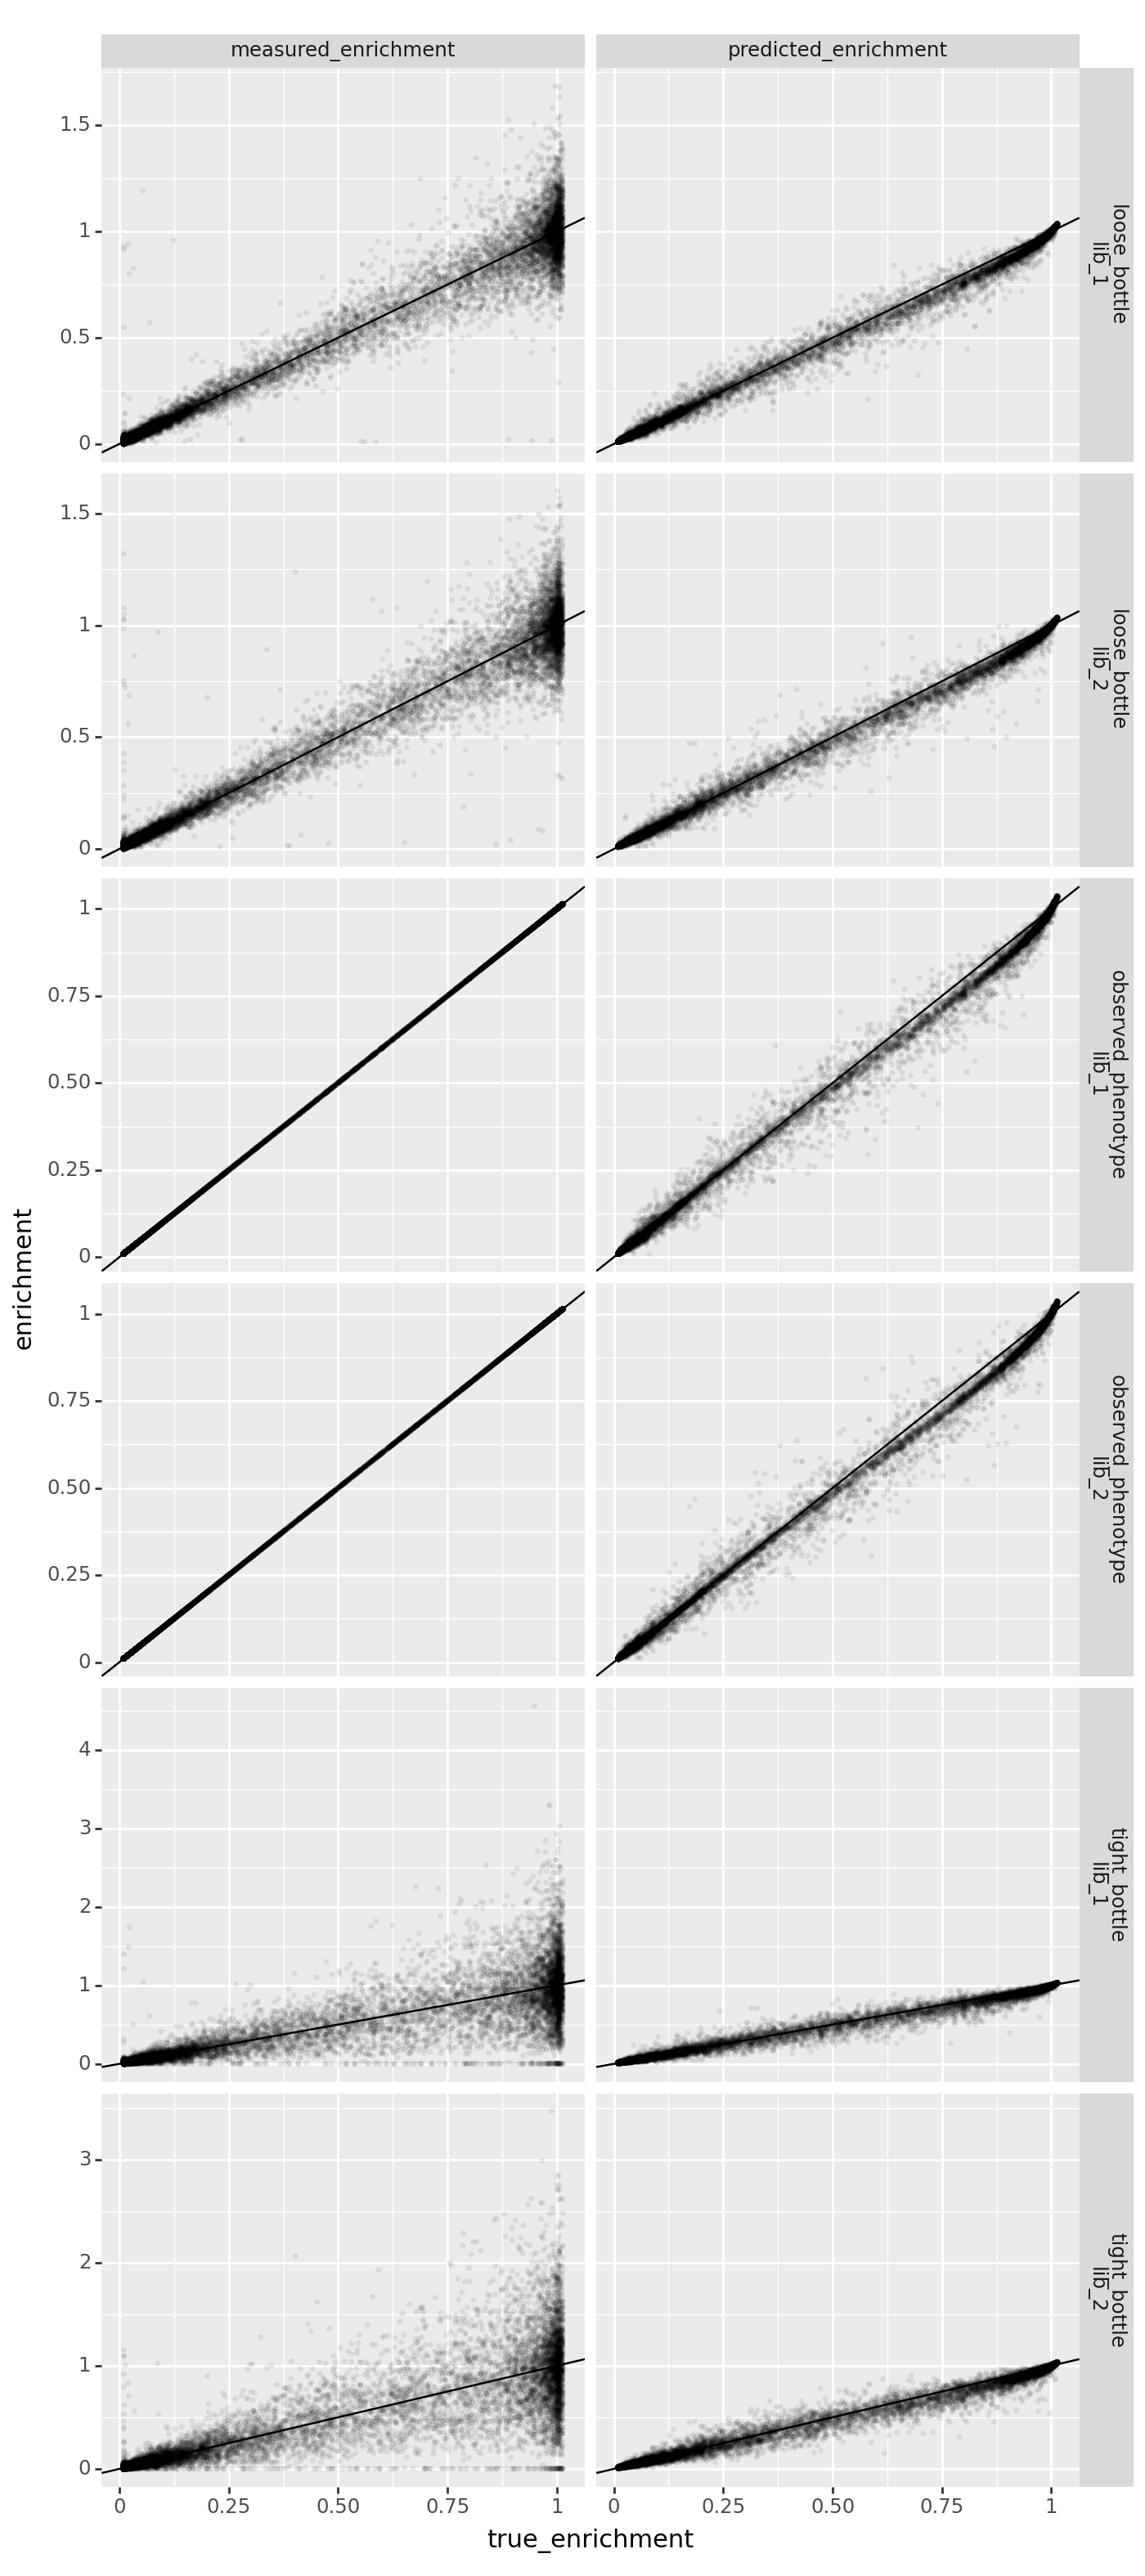

In [100]:
p = (
    ggplot(
        data.melt(
            # id_vars=["measurement_type", "library", "condition", "true_enrichment"],
            id_vars=["measurement_type", "library", "true_enrichment"],
            value_vars=["predicted_enrichment", "measured_enrichment"],
            var_name="enrichment_type",
            value_name="enrichment",
        ),
        # variants_df,
        aes("true_enrichment", "enrichment"),
    )
    + geom_abline(
        slope=1,
        intercept=0, 
        # alpha=0.5,
        # size=0.5,
    )
    + geom_point(alpha=0.05, size=0.5)
    # + facet_grid("measurement_type + library + condition ~ enrichment_type", scales="free_y")
    + facet_grid("measurement_type + library ~ enrichment_type", scales="free_y")
    + theme(
        figure_size=(
            7,
            2.75 * (variants_df["measurement_type"].nunique() + variants_df["library"].nunique()) + variants_df["condition"].nunique(),
        )
    )
)

_ = p.draw(show=True)

Next, let's take a look at the inferred shift parameters for each of the libraries.

Next, we would like to know how the libraries correlate.

We'll start by splitting the prepped functional scores into a training and test set.

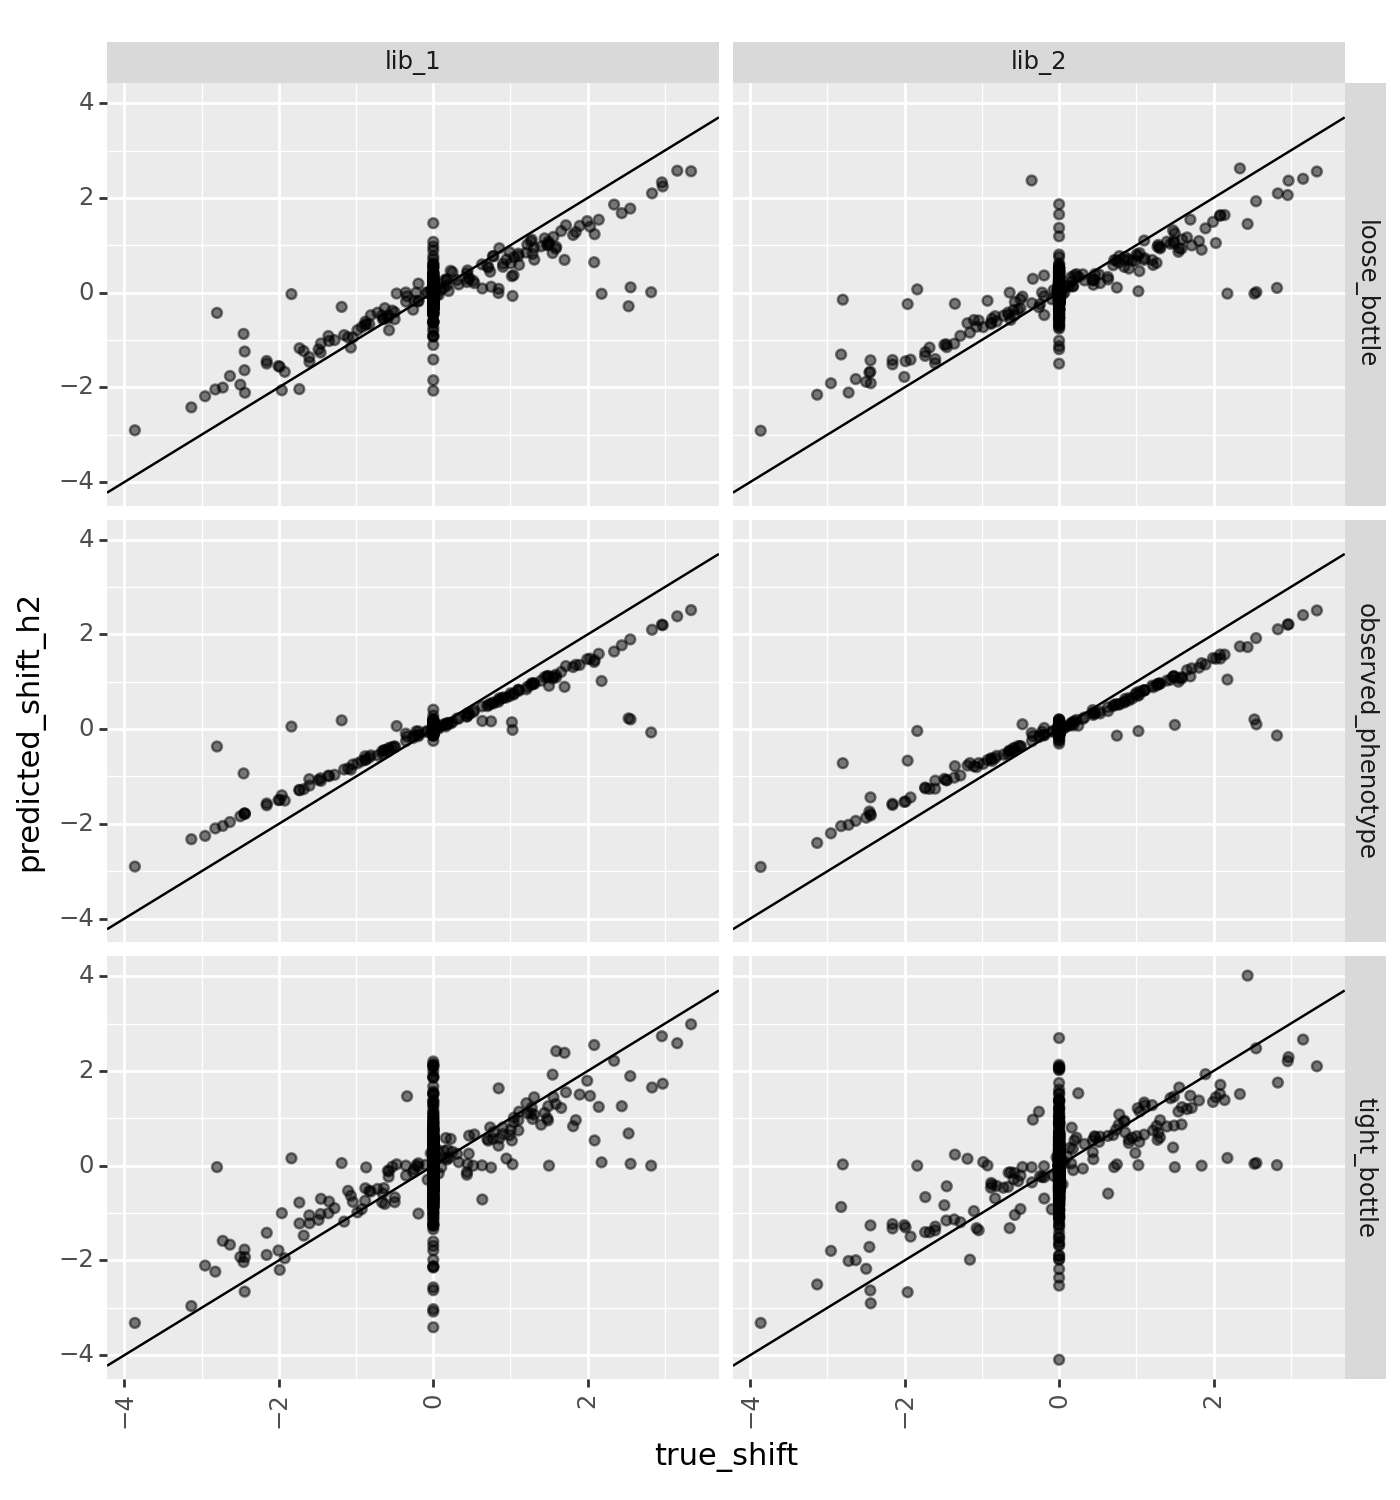

In [109]:
# plot correlations of true and predicted shifts
for (x, y) in itertools.combinations(
    ["true_shift", "predicted_shift_h2"], 2
):
    p = (
        # ggplot(mutations_df.query("lasso == 1e-05"))
        ggplot(mutations_df.query(f"lasso == 1e-5"))
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
            # size=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
            # size=0.5,
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(7 , 7.5),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
    )
    _ = p.draw(show=True)

In [105]:
fit_collection.query("scale_coeff_lasso_shift == 2e-4 & library == 'lib_1' & measurement_type == 'loose_bottle'")

model                   dataset_name  \
5  Model(Model-0)  lib_1_loose_bottle_func_score   

                                  step_loss epistatic_model output_activation  \
5  [8.948822093580924, 0.34987186949146587]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
5                  0.0002                    0.0                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ... iterations_per_step  \
5                       0                         0  ...               10000   

  n_hidden_units lower_bound PRNGKey infer_beta_naught measurement_type  \
5              5        None       0              5.37     loose_bottle   

  library variant_phenotype_corr beta_corr shift_corr  
5   lib_1               0.968209  0.980698   0.825339  

[1 rows x 27 columns]

In [106]:
fit_collection.loc[5, "model"].mut_param_heatmap()

alt.VConcatChart(...)

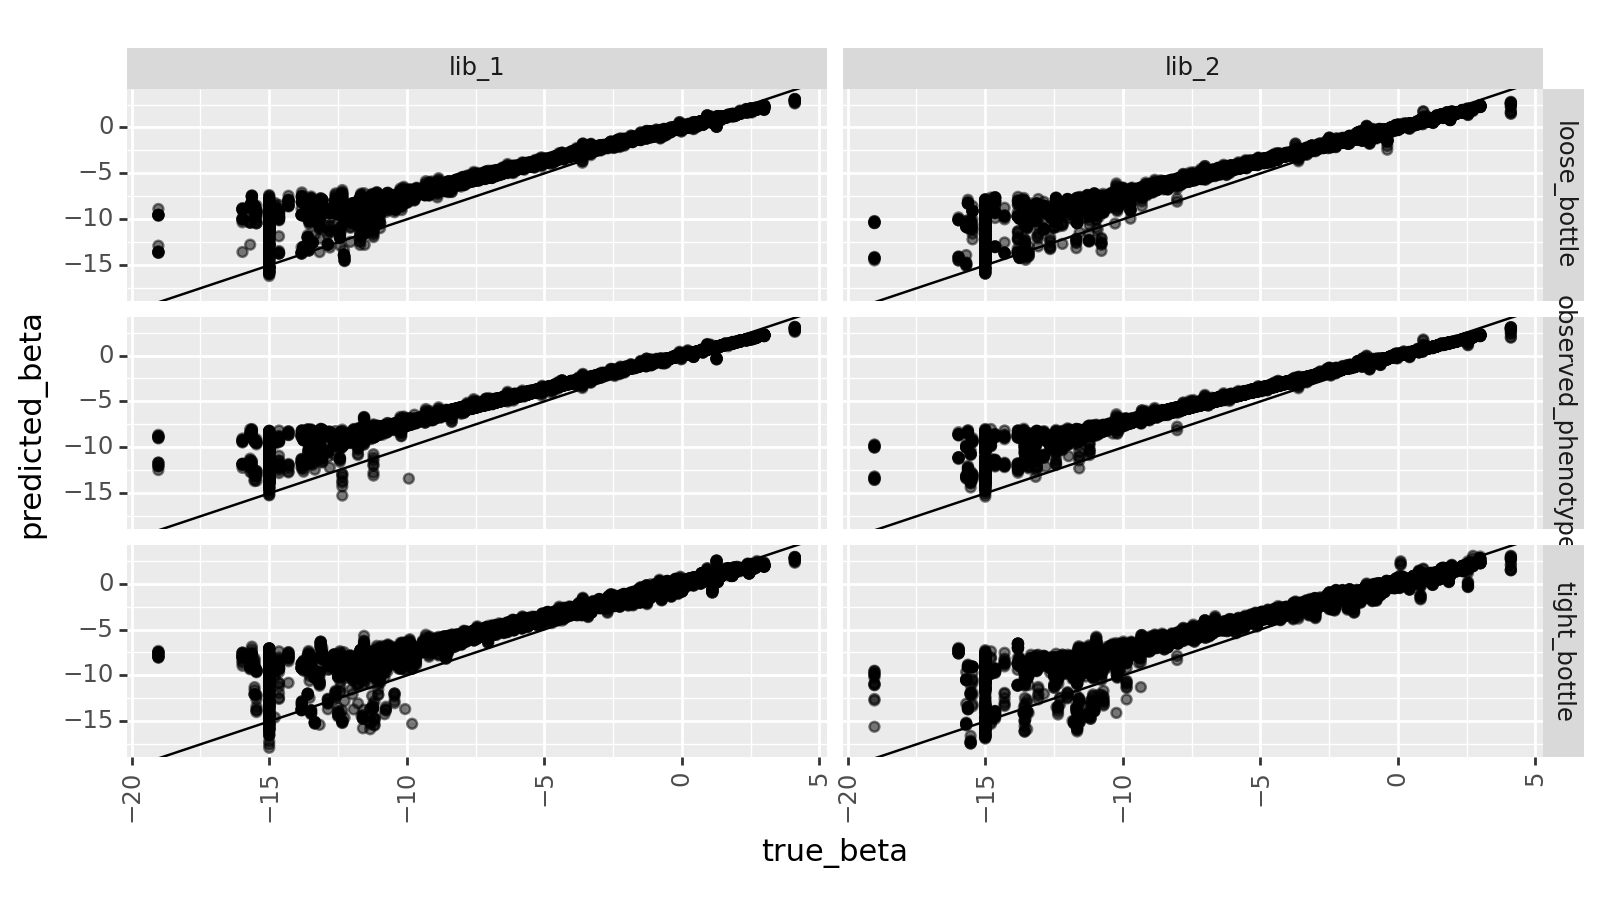

In [55]:
 # plot correlations of true and predicted shifts
for (x, y) in itertools.combinations(
    ["true_beta", "predicted_beta"], 2
):
    p = (
        ggplot(mutations_df)
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
            # size=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(4 * len(libs), 2.25 * len(bottlenecks)),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
    )
    _ = p.draw(show=True)

### Cross validation

We would like to know if cross validation can help us select the best model. We can do this by breaking the variant data into a training and test set, and then fitting the model to the training set and evaluating the model on the test set. 

In [55]:
func_scores

library condition                         aa_substitutions  \
0       lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1       lib_1        h1                       V8P H27T P30* L49P   
2       lib_1        h1                                V19P V43Q   
3       lib_1        h1                                     R20Y   
4       lib_1        h1                                            
...       ...       ...                                      ...   
60719   lib_2        h2                      V24P Q28L T36A G37A   
60720   lib_2        h2                                V19Y P30T   
60721   lib_2        h2                                V24S P30*   
60722   lib_2        h2                                V19L N46A   
60723   lib_2        h2                       P6R R20S T35S S47I   

           func_score_type  func_score     variant_class  
0      observed_enrichment    0.010000  >1 nonsynonymous  
1      observed_enrichment    0.010000              stop  
2      observed_enrichment    0.010142  >1 nonsynonymous  
3      observed_enrichment    0.952440   1 nonsynonymous  
4      observed_enrichment    1.000000          wildtype  
...                    ...         ...               ...  
60719         tight_bottle   -6.911844  >1 nonsynonymous  
60720         tight_bottle   -6.714807  >1 nonsynonymous  
60721         tight_bottle   -5.057695              stop  
60722         tight_bottle   -0.909796  >1 nonsynonymous  
60723         tight_bottle   -6.311452  >1 nonsynonymous  

[242176 rows x 6 columns]

In [56]:
data = func_scores.query("library == 'lib_1' & func_score_type == 'loose_bottle'").sample(frac=1, random_state=seed)
train_df, test_df = data.iloc[:int(len(data) * 0.8)], data.iloc[int(len(data) * 0.8):]

In [57]:
train_df["condition"].value_counts()

condition
h2    12136
h1    12088
Name: count, dtype: int64

In [58]:
test_df["condition"].value_counts()

condition
h2    3049
h1    3008
Name: count, dtype: int64

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24224 entries, 86 to 13800
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   library           24224 non-null  object 
 1   condition         24224 non-null  object 
 2   aa_substitutions  24224 non-null  object 
 3   func_score_type   24224 non-null  object 
 4   func_score        24224 non-null  float64
 5   variant_class     24224 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.3+ MB


In [60]:
train, test = [
    multidms.Data(
        fs_df, 
        reference="h1", 
        alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
        verbose=False,
        name = name 
    )
    for fs_df, name in zip([train_df, test_df], ["train", "test"])
]

In [61]:
print(f"training set has {len(train.mutations)}")
print(f"testing set has {len(test.mutations)}")
print(f"They share {len(set.intersection(set(train.mutations), set(test.mutations)))} mutation")
print(f"Testing has {len(set(test.mutations) - set(train.mutations))} mutations not in training")
print(f"Training has {len(set(train.mutations) - set(test.mutations))} mutations not in testing")

training set has 1000
testing set has 999
They share 999 mutation
Testing has 0 mutations not in training
Training has 1 mutations not in testing


In [62]:

model_collection_params = {
    "dataset": [train],

    "num_training_steps" : [1],
    "iterations_per_step": [10000], # default 20000

    "scale_coeff_lasso_shift": [0.0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 3e-4],
    # "scale_coeff_lasso_shift": [2e-5],

    "init_beta_naught" : [5.0],
    # "alpha_d" : [True, False],

    "scale_coeff_ridge_beta" : [0.0], # we've found that a small ridge penalty is really quite helpful for the model to not get stuck at weird local minima
}
_, _, fit_collection = multidms.model_collection.fit_models(model_collection_params, n_threads=24)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [63]:
fit_collection

model dataset_name                                step_loss  \
0  Model(Model-0)        train   [8.92626925109163, 0.3395842104165843]   
1  Model(Model-0)        train  [8.92626925109163, 0.34002008834063463]   
2  Model(Model-0)        train   [8.92626925109163, 0.3407389473571916]   
3  Model(Model-0)        train   [8.92626925109163, 0.3428463975805528]   
4  Model(Model-0)        train   [8.92626925109163, 0.3455707579797899]   
5  Model(Model-0)        train  [8.92626925109163, 0.35031757878846165]   
6  Model(Model-0)        train  [8.92626925109163, 0.35494261975268504]   

  epistatic_model output_activation scale_coeff_lasso_shift  \
0         Sigmoid          Identity                     0.0   
1         Sigmoid          Identity                 0.00001   
2         Sigmoid          Identity                 0.00002   
3         Sigmoid          Identity                 0.00005   
4         Sigmoid          Identity                  0.0001   
5         Sigmoid          Identity                  0.0002   
6         Sigmoid          Identity                  0.0003   

  scale_coeff_ridge_beta scale_coeff_ridge_shift scale_coeff_ridge_gamma  \
0                    0.0                       0                       0   
1                    0.0                       0                       0   
2                    0.0                       0                       0   
3                    0.0                       0                       0   
4                    0.0                       0                       0   
5                    0.0                       0                       0   
6                    0.0                       0                       0   

  scale_coeff_ridge_alpha_d  ... gamma_corrected alpha_d init_beta_naught  \
0                         0  ...           False   False              5.0   
1                         0  ...           False   False              5.0   
2                         0  ...           False   False              5.0   
3                         0  ...           False   False              5.0   
4                         0  ...           False   False              5.0   
5                         0  ...           False   False              5.0   
6                         0  ...           False   False              5.0   

  lock_beta_naught_at     tol num_training_steps iterations_per_step  \
0                None  0.0001                  1               10000   
1                None  0.0001                  1               10000   
2                None  0.0001                  1               10000   
3                None  0.0001                  1               10000   
4                None  0.0001                  1               10000   
5                None  0.0001                  1               10000   
6                None  0.0001                  1               10000   

  n_hidden_units lower_bound PRNGKey  
0              5        None       0  
1              5        None       0  
2              5        None       0  
3              5        None       0  
4              5        None       0  
5              5        None       0  
6              5        None       0  

[7 rows x 21 columns]

In [64]:
test_df

library condition     aa_substitutions func_score_type  func_score  \
6119    lib_1        h2             S9G F40*    loose_bottle   -6.474940   
15072   lib_1        h2             T7* T36P    loose_bottle   -5.604741   
544     lib_1        h1         S3I G6L C31R    loose_bottle   -5.817017   
4027    lib_1        h2            Y39S L49T    loose_bottle   -7.252229   
12153   lib_1        h1       Y39H L46T G50V    loose_bottle   -9.313443   
...       ...       ...                  ...             ...         ...   
4761    lib_1        h2    S3V P6L T36W N46L    loose_bottle   -0.481876   
9823    lib_1        h2  T16K T23* D29G W38R    loose_bottle   -7.418457   
14528   lib_1        h1     S2H F4V V8S Y38A    loose_bottle   -6.221712   
899     lib_1        h1                 L17T    loose_bottle   -0.072238   
12706   lib_1        h1         S5V T7G C32G    loose_bottle   -6.877558   

          variant_class  
6119               stop  
15072              stop  
544    >1 nonsynonymous  
4027   >1 nonsynonymous  
12153  >1 nonsynonymous  
...                 ...  
4761   >1 nonsynonymous  
9823               stop  
14528  >1 nonsynonymous  
899     1 nonsynonymous  
12706  >1 nonsynonymous  

[6057 rows x 6 columns]

In [65]:
test_df.reset_index(inplace=True)

In [66]:
for idx, fit in fit_collection.iterrows():
    test_df = fit["model"].add_phenotypes_to_df(
        test_df,
        latent_phenotype_col=f"predicted_latent_{fit.scale_coeff_lasso_shift}",
        observed_phenotype_col=f"predicted_func_score_{fit.scale_coeff_lasso_shift}",
        converted_substitutions_col=f"aa_subs_wrt_ref_{fit.scale_coeff_lasso_shift}",
        unknown_as_nan=True,
        phenotype_as_effect=False,
    )

In [67]:
test_df_tall = (
    test_df
    .melt(
        id_vars=["condition", "aa_substitutions", "func_score"],
        value_vars=[f"predicted_func_score_{fit.scale_coeff_lasso_shift}" for _, fit in fit_collection.iterrows()],
        var_name="scale_coeff_lasso_shift",
        value_name="predicted_func_score"
    )
)
test_df_tall["scale_coeff_lasso_shift"] = test_df_tall["scale_coeff_lasso_shift"].str.split("_").str[-1].astype(object)
test_df_tall

condition     aa_substitutions  func_score scale_coeff_lasso_shift  \
0            h2             S9G F40*   -6.474940                     0.0   
1            h2             T7* T36P   -5.604741                     0.0   
2            h1         S3I G6L C31R   -5.817017                     0.0   
3            h2            Y39S L49T   -7.252229                     0.0   
4            h1       Y39H L46T G50V   -9.313443                     0.0   
...         ...                  ...         ...                     ...   
42394        h2    S3V P6L T36W N46L   -0.481876                  0.0003   
42395        h2  T16K T23* D29G W38R   -7.418457                  0.0003   
42396        h1     S2H F4V V8S Y38A   -6.221712                  0.0003   
42397        h1                 L17T   -0.072238                  0.0003   
42398        h1         S5V T7G C32G   -6.877558                  0.0003   

       predicted_func_score  
0                 -6.610233  
1                 -6.610233  
2                 -6.076083  
3                 -6.476474  
4                 -6.609921  
...                     ...  
42394             -0.254309  
42395             -6.614568  
42396             -6.614562  
42397             -0.067890  
42398             -6.614517  

[42399 rows x 5 columns]

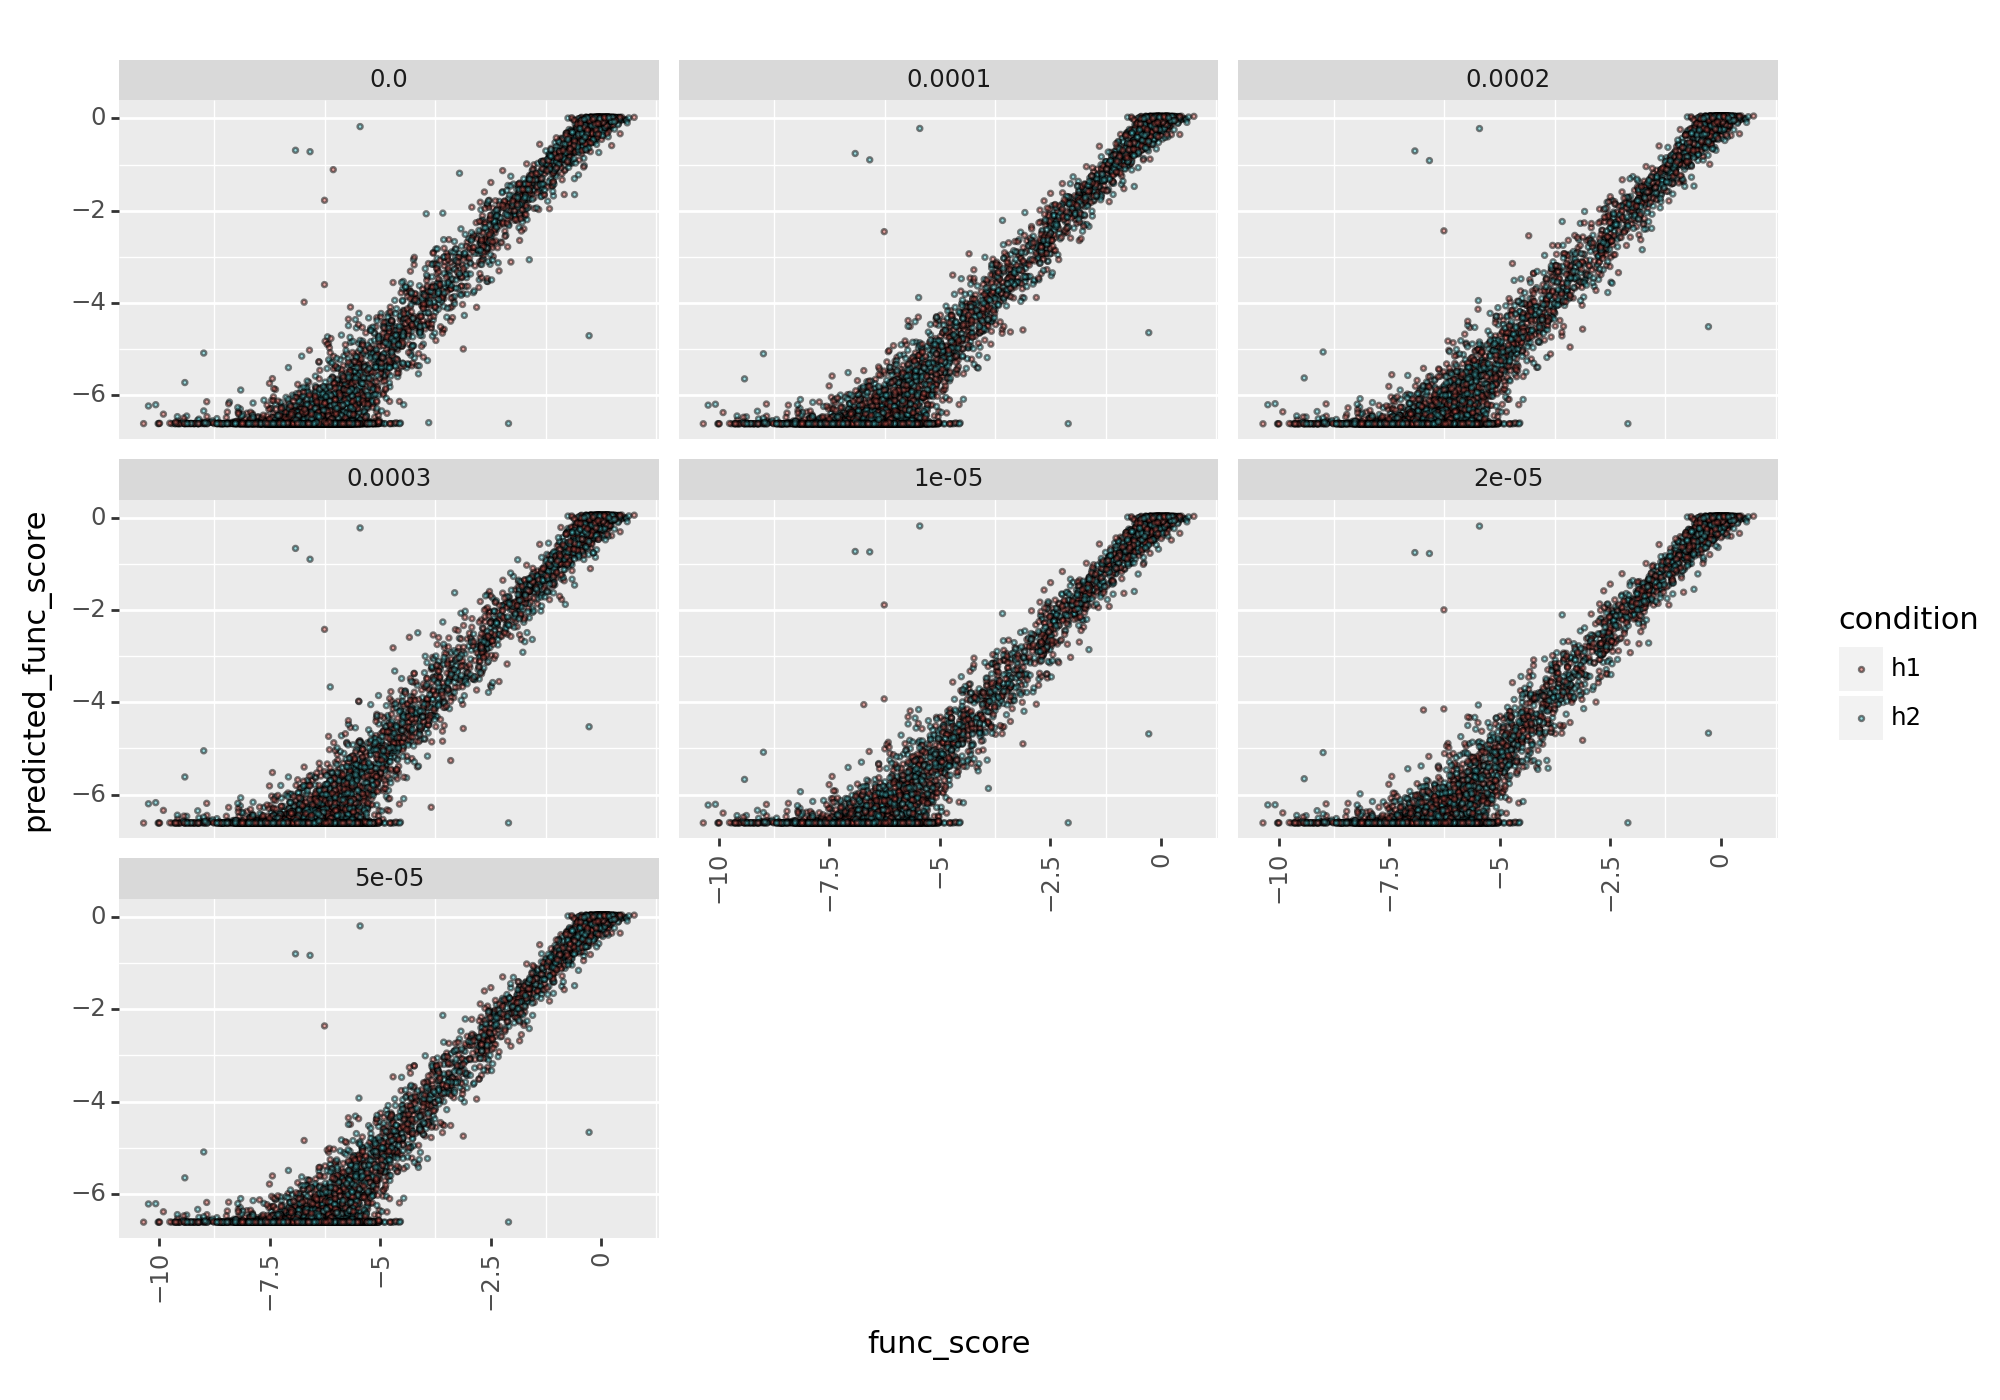

In [68]:
p = (
    ggplot(test_df_tall)
    + geom_point(
        aes(
            x="func_score",
            y="predicted_func_score",
            fill="condition"
        ),
        alpha=0.5,
        size=0.5
    )
    + facet_wrap("~scale_coeff_lasso_shift")
    + theme(
        figure_size=(10, 7),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    # + scale_fill_manual(values=CBPALETTE[1:], guide=False)
)
_ = p.draw(show=True)

In [69]:
from collections import defaultdict

In [70]:
data = defaultdict(list)
for lasso in model_collection_params["scale_coeff_lasso_shift"]:
    data["lasso"].append(lasso)
    data["pearsonr"].append(
        test_df["func_score"].corr(test_df[f"predicted_func_score_{lasso}"])
    )
data = pd.DataFrame(data)
data["lasso"] = data["lasso"].astype(object)
data

lasso  pearsonr
0      0.0  0.964728
1  0.00001  0.965691
2  0.00002  0.965962
3  0.00005  0.966402
4   0.0001  0.966511
5   0.0002  0.966120
6   0.0003  0.965493

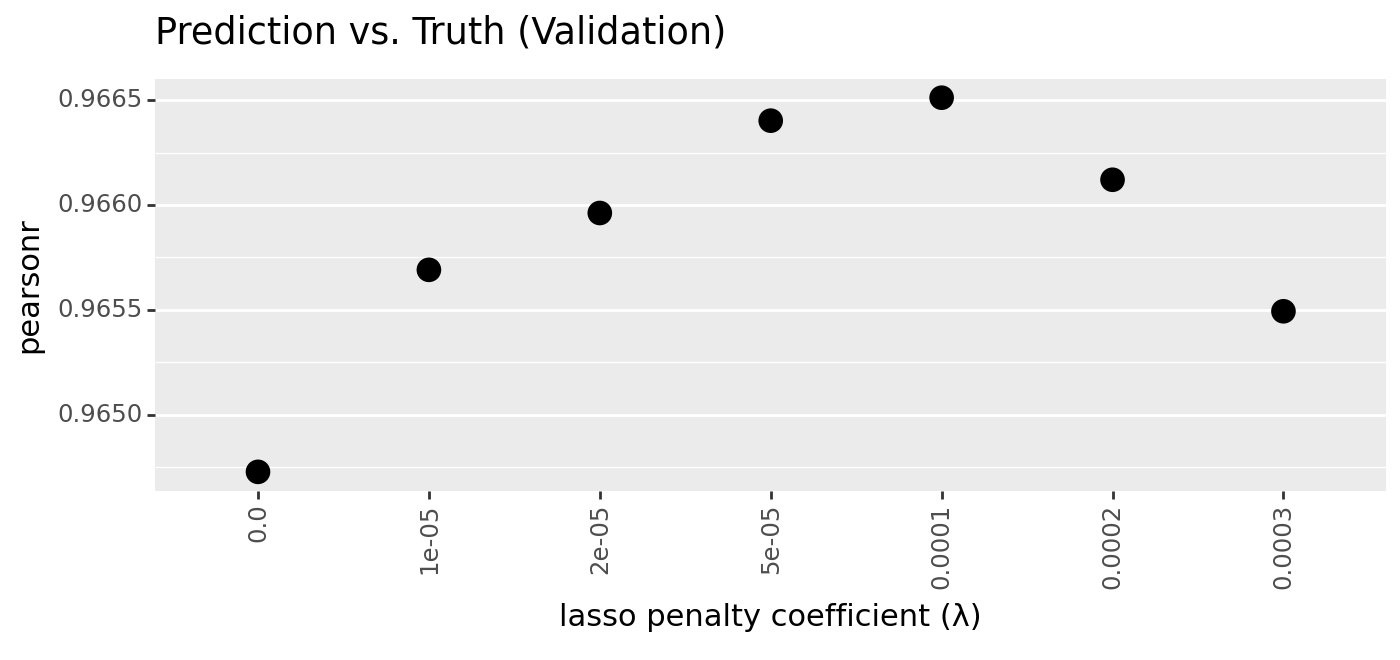

In [71]:
p = (
    ggplot(data)
    + geom_line(
        aes(
            x="lasso",
            y="pearsonr"
        ),
    )
    + geom_point(
        aes(
            x="lasso",
            y="pearsonr"
        ),
        size=4
    )
    + theme(
        figure_size=(7, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        title=f"Prediction vs. Truth (Validation)",
        x="lasso penalty coefficient (λ)",
        y="pearsonr"
    )
)
_ = p.draw(show=True)

In [72]:
# %load_ext autoreload
# %autoreload 2
# import multidms

In [73]:
train, test = [], {}
for (library, measurement), fs_df in func_scores.groupby(["library", "func_score_type"]):
    
    if "enrichment" in measurement:
        continue

    print(library, measurement)
    dataset = fs_df.sample(frac=1, random_state=seed)
    train_split, test_split = dataset.iloc[:int(len(dataset) * 0.8)], dataset.iloc[int(len(dataset) * 0.8):]
    name = f"{library}_{measurement}"
    
    train.append(
        multidms.Data(
            train_split, 
            reference="h1", 
            alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
            verbose=False,
            name = name
        )
    )

    test[name] = test_split

lib_1 loose_bottle
lib_1 observed_phenotype
lib_1 tight_bottle
lib_2 loose_bottle
lib_2 observed_phenotype
lib_2 tight_bottle


In [74]:
model_collection_params = {
    "dataset": train,

    "num_training_steps" : [1],
    "iterations_per_step": [10000], # default 20000

    "scale_coeff_lasso_shift": [0.0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 3e-4],
    # "scale_coeff_lasso_shift": [2e-5],

    "init_beta_naught" : [5.0],
    # "alpha_d" : [True, False],

    "scale_coeff_ridge_beta" : [0.0], # we've found that a small ridge penalty is really quite helpful for the model to not get stuck at weird local minima
}
_, _, fit_collection = multidms.model_collection.fit_models(model_collection_params, n_threads=24)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun 

In [75]:
def add_validation_loss(fit_collection, test_data, overwrite=False):
    """
    Add validation loss to the fit collection dataframe.

    Parameters
    ----------
    test_data : pd.DataFrame or dict(str, pd.DataFrame)
        The testing dataframe to compute validation loss with respect to, 
        must have columns "aa_substitutitions", "condition", and "func_score". 
        If a dictionary is passed, there should be a key for 
        each unique dataset_name factor in the fit_collection dataframe 
        - with the value being the respective testing dataframe.

    Returns
    -------
    pd.DataFrame
        The fit_collection dataframe with the validation loss added.    
    """
    if isinstance(test_data, pd.DataFrame):
        temp_test_data = test_data.copy()
        test_data = {}
        for name in fit_collection["dataset_name"].unique():
            test_data[name] = temp_test_data

    # check there's a testing dataframe for each unique dataset_name
    assert set(test_data.keys()) == set(fit_collection["dataset_name"].unique())
    
    if "validation_loss" in fit_collection.columns and not overwrite:
        raise ValueError("validation_loss already exists in fit_collection, set overwrite=True to overwrite")
    
    fit_collection["validation_loss"] = np.nan
    for idx, fit in fit_collection.iterrows():
        fit_collection.loc[idx, "validation_loss"] = fit["model"].get_df_loss(test_data[fit["dataset_name"]])

    return None

In [76]:
add_validation_loss(fit_collection, test, overwrite=True)

In [77]:
fit_collection["training_loss"] = [float(row.model.loss) for _, row in fit_collection.iterrows()]
fit_collection["measurement_type"] = fit_collection["dataset_name"].str.split("_").str[2:4].str.join("_")
fit_collection["library"] = fit_collection["dataset_name"].str.split("_").str[0:2].str.join("_")
# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
fit_collection["measurement_type"] = pd.Categorical(
    fit_collection["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
fit_collection.head()

model        dataset_name  \
0  Model(Model-0)  lib_1_loose_bottle   
1  Model(Model-0)  lib_1_loose_bottle   
2  Model(Model-0)  lib_1_loose_bottle   
3  Model(Model-0)  lib_1_loose_bottle   
4  Model(Model-0)  lib_1_loose_bottle   

                                 step_loss epistatic_model output_activation  \
0   [8.92626925109163, 0.3395842104165843]         Sigmoid          Identity   
1  [8.92626925109163, 0.34002008834063463]         Sigmoid          Identity   
2   [8.92626925109163, 0.3407389473571916]         Sigmoid          Identity   
3   [8.92626925109163, 0.3428463975805528]         Sigmoid          Identity   
4   [8.92626925109163, 0.3455707579797899]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                     0.0                    0.0                       0   
1                 0.00001                    0.0                       0   
2                 0.00002                    0.0                       0   
3                 0.00005                    0.0                       0   
4                  0.0001                    0.0                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ...     tol  \
0                       0                         0  ...  0.0001   
1                       0                         0  ...  0.0001   
2                       0                         0  ...  0.0001   
3                       0                         0  ...  0.0001   
4                       0                         0  ...  0.0001   

  num_training_steps iterations_per_step n_hidden_units lower_bound PRNGKey  \
0                  1               10000              5        None       0   
1                  1               10000              5        None       0   
2                  1               10000              5        None       0   
3                  1               10000              5        None       0   
4                  1               10000              5        None       0   

  validation_loss training_loss measurement_type library  
0        0.370897      0.339584     loose_bottle   lib_1  
1        0.363034      0.340020     loose_bottle   lib_1  
2        0.360351      0.340739     loose_bottle   lib_1  
3        0.356154      0.342846     loose_bottle   lib_1  
4        0.355081      0.345571     loose_bottle   lib_1  

[5 rows x 25 columns]

In [78]:
fit_collection[["scale_coeff_lasso_shift", "library", "measurement_type", "training_loss", "validation_loss"]].head()
# fit_collection[["scale_coeff_lasso_shift", "library", "measurement_type", "training_loss", "validation_loss"]].info()

scale_coeff_lasso_shift library measurement_type  training_loss  \
0                     0.0   lib_1     loose_bottle       0.339584   
1                 0.00001   lib_1     loose_bottle       0.340020   
2                 0.00002   lib_1     loose_bottle       0.340739   
3                 0.00005   lib_1     loose_bottle       0.342846   
4                  0.0001   lib_1     loose_bottle       0.345571   

   validation_loss  
0         0.370897  
1         0.363034  
2         0.360351  
3         0.356154  
4         0.355081

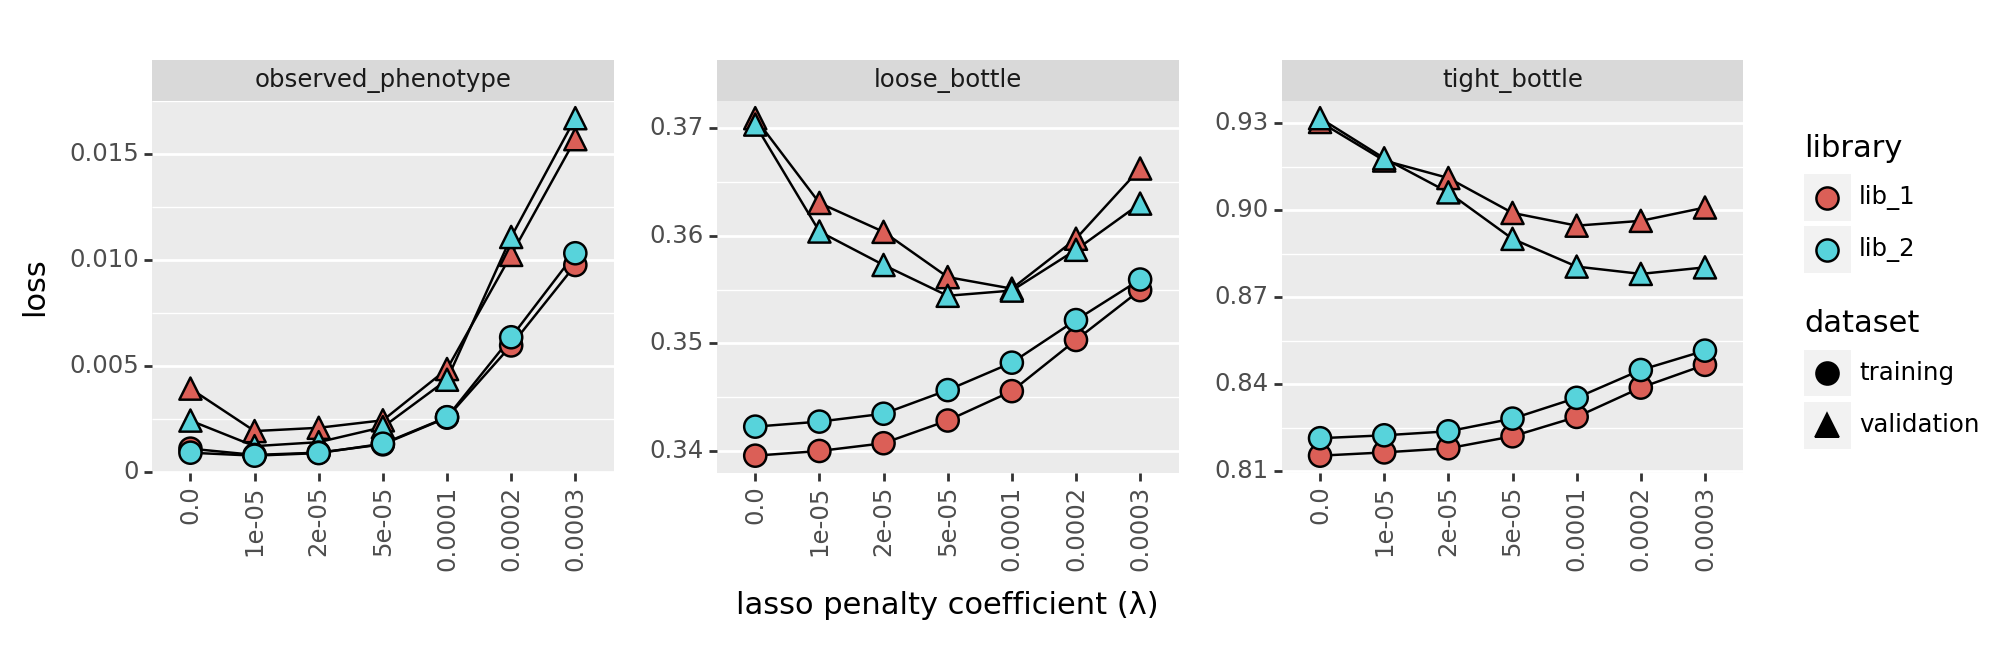

In [79]:
data = (
    fit_collection
    .melt(
        id_vars=["scale_coeff_lasso_shift", "library", "measurement_type"],
        value_vars=["training_loss", "validation_loss"],
        var_name="dataset",
        value_name="loss",
    )
    .assign(
        dataset = lambda x: x["dataset"].str.replace("_loss", "")
    )
    .assign(
        lib_dataset = lambda x: x["library"] + " " + x["dataset"]
    )
)
p = (
    ggplot(data)
    + geom_line(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"loss",
            group="lib_dataset",
        )
    )
    + geom_point(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"loss",
            fill="library",
            shape="dataset"
        ),
        size=4
    )
    + facet_wrap("measurement_type", scales="free_y")
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        x="lasso penalty coefficient (λ)",
        y="loss"
    )
)
_ = p.draw(show=True)